<a href="https://colab.research.google.com/github/Faza20-lab/Projet_stats/blob/Marine/Projet_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I/ Preset**

In [81]:
!pip install netCDF4

In [82]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.stats as st
from scipy.stats import norm, gamma, beta, shapiro, kstest, genextreme, genpareto, probplot, kendalltau, rankdata
import statsmodels.api as sm
from statsmodels.stats.diagnostic import anderson_statistic
from scipy.stats import beta as beta_dist
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.integrate import quad
from scipy.optimize import root_scalar

In [83]:
from google.colab import drive
drive.mount('/content/drive')

file_prec = '/content/drive/MyDrive/data/ERA5_prec_daily_1940_2023_FR_brittany.nc'
ds = xr.open_dataset(file_prec)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **II/ Visualisation des données:**


## Visualisation des données de precipitations et définition de X:

In [84]:
ds.sizes

Frozen({'Latitude': 12, 'Longitude': 14, 'time': 30449})

In [85]:
print(ds['time'])

<xarray.DataArray 'time' (time: 30449)> Size: 244kB
array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', ..., '2023-05-11T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-05-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 244kB 1940-01-01 1940-01-02 ... 2023-05-13
    height   float64 8B ...


In [86]:
ds.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [87]:
print(ds.Latitude.values)
print(ds.Longitude.values)

[49.   48.75 48.5  48.25 48.   47.75 47.5  47.25 47.   46.75 46.5  46.25]
[-4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.
 -1.75 -1.5 ]


Le dataset complet (ds) contient les niveaux de précipitation en (kg/m3/s) sur toute la Bretagne par jour de 1940 à 2023.
Il y a en tout 30 449 jours.

**On trace ensuite une carte du premier jour:** 01/01/1940

In [88]:
da = ds['pr'].isel(time=0)   # sélection du premier pas de temps (un jour = une carte)
df = da.to_dataframe().reset_index() # pandas dataframe du premier jour sur toutes les long. lat. de la bretagne

In [89]:
print(da)

<xarray.DataArray 'pr' (Latitude: 12, Longitude: 14)> Size: 672B
[168 values with dtype=float32]
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
    time       datetime64[ns] 8B 1940-01-01
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...


In [90]:
print(df.head())

   Latitude  Longitude       time   lon   lat  height  pr
0      49.0      -4.75 1940-01-01 -4.75  49.0     0.0 NaN
1      49.0      -4.50 1940-01-01 -4.50  49.0     0.0 NaN
2      49.0      -4.25 1940-01-01 -4.25  49.0     0.0 NaN
3      49.0      -4.00 1940-01-01 -4.00  49.0     0.0 NaN
4      49.0      -3.75 1940-01-01 -3.75  49.0     0.0 NaN


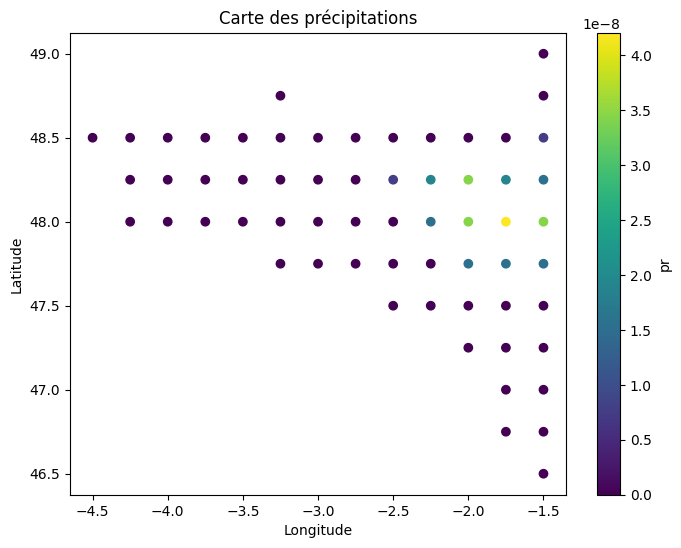

In [91]:
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["pr"])
plt.colorbar(label="pr")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte des précipitations")
plt.show()

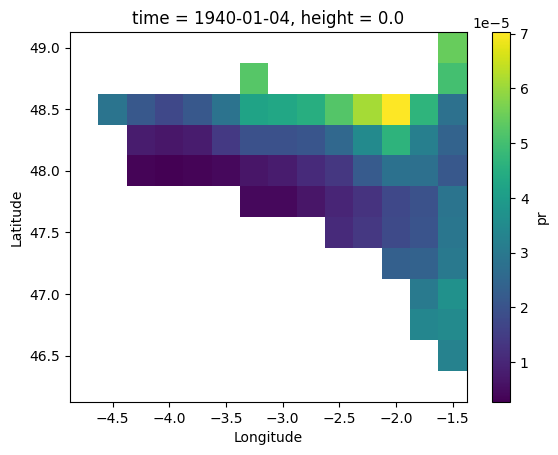

In [92]:
ds.pr[:,:,3].plot() #  On peut aussi tracer comme ça trace ici c'est le jour 4 (04/01/1940)

**Maintenant on sélectionne les mois qui nous intéressent.** Ici Décembre, janvier, février. On appelle ce dataset ds_djf.

In [93]:
ds_djf = ds.sel(time=ds['time'].dt.month.isin([1, 2, 12]))  # sélection des mois DJF
print(ds_djf)
ds_djf.sizes # dimensions du dataset

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    pr         (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

Ce dataset contient maintenant **7550 jours**.
On fait ensuite la **somme par jour des précipitations** sur toute la Bretagne, on appelle cette variable **X**.

In [94]:
# Somme quotidienne des précipitations sur toute la zone en mois DJF
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])  # somme spatiale
print(somme_quotidienne_pr_djf)

X = somme_quotidienne_pr_djf
print(len(X))  # nombre de jours

<xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539758e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685731e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


In [165]:
type(X)

xarray.core.dataarray.DataArray

On **convertit** X de kg/m2/s en mm-1 et on met à jour X.

1 kg/m² = 1 mm d’eau.
Il faut donc multiplier par le nombre de secondes dans une journée.

In [15]:
print("X en kg/m2/s", X)
#conversion de kg/m²/s en mm-1
seconds_per_day = 24 * 60 * 60  # 86400

X_mm_per_day = X * seconds_per_day # x(1000/1000)

# Mettre à jour le DataArray avec une nouvelle unité
X = X_mm_per_day.rename("pr_mm_per_day")
X.attrs['units'] = 'mm/day'
X.attrs['description'] = 'Précipitation journalière convertie de kg/m²/s → mm/j'

print("X en mm-1", X)

X en kg/m2/s <xarray.DataArray 'pr' (time: 7550)> Size: 30kB
array([2.7539758e-07, 0.0000000e+00, 3.9131618e-03, ..., 1.3772695e-05,
       2.4685731e-05, 2.1683841e-03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
X en mm-1 <xarray.DataArray 'pr_mm_per_day' (time: 7550)> Size: 30kB
array([2.3794351e-02, 0.0000000e+00, 3.3809717e+02, ..., 1.1899608e+00,
       2.1328471e+00, 1.8734839e+02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
Attributes:
    units:        mm/day
    description:  Précipitation journalière convertie de kg/m²/s → mm/j
<xarray.DataArray 'pr' (Latitude: 5, Longitude: 5, time: 5)> Size: 500B
array([[[         nan,          nan,          nan,          nan,
                  nan],
        [         nan,          nan,          nan,          nan,
                  nan],
        [         nan,   

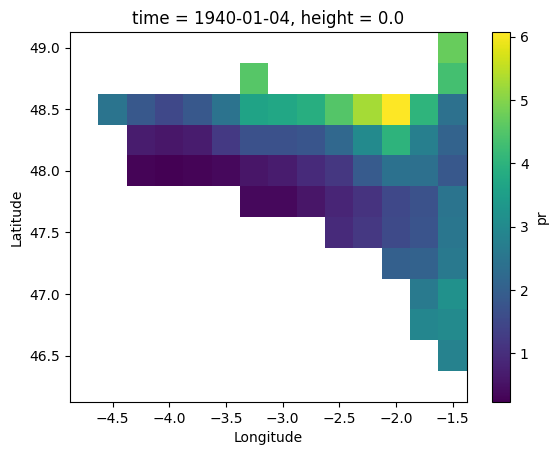

In [163]:
ds_djf['pr'] = ds['pr'] * 86400  # on convertit aussi le dataset en mm-1
ds_djf.pr[:,:,3].plot()

## Visualisation des données de vents et définition de Y:

In [97]:
file_wind = '/content/drive/MyDrive/data/ERA5_wind_daily_1940_2023_FR_brittany.nc'
ds2 = xr.open_dataset(file_wind)

In [98]:
ds2.head()

<xarray.Dataset> Size: 708B
Dimensions:    (Latitude: 5, Longitude: 5, time: 5)
Coordinates:
  * Latitude   (Latitude) float64 40B 49.0 48.75 48.5 48.25 48.0
  * Longitude  (Longitude) float64 40B -4.75 -4.5 -4.25 -4.0 -3.75
  * time       (time) datetime64[ns] 40B 1940-01-01 1940-01-02 ... 1940-01-05
    lon        (Longitude) float64 40B ...
    lat        (Latitude) float64 40B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 500B ...

In [99]:
ds2.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000',
       '1940-01-11T00:00:00.000000000', '1940-01-12T00:00:00.000000000',
       '1940-01-13T00:00:00.000000000', '1940-01-14T00:00:00.000000000',
       '1940-01-15T00:00:00.000000000', '1940-01-16T00:00:00.000000000',
       '1940-01-17T00:00:00.000000000', '1940-01-18T00:00:00.000000000',
       '1940-01-19T00:00:00.000000000', '1940-01-20T00:00:00.000000000',
       '1940-01-21T00:00:00.000000000', '1940-01-22T00:00:00.000000000',
       '1940-01-23T00:00:00.000000000', '1940-01-24T00:00:00.000000000',
       '1940-01-25T00:00:00.000000000', '1940-01-26T00:00:00.000000000',
       '1940-01-27T00:00:00.000000000', '1940-01-28

Le dataset complet (ds2) contient les maximums de vent par jour (m/s) sur toute la Bretagne de 1940 à 2023.
Il y a en tout 30 449 jours.

On ne garde ensuite que décembre, janvier, février (7550jours).

In [100]:
ds2_djf = ds2.sel(time=ds2['time'].dt.month.isin([1, 2, 12]))  # sélection des mois DJF
print(ds2_djf)
ds2_djf.sizes

<xarray.Dataset> Size: 5MB
Dimensions:    (Latitude: 12, Longitude: 14, time: 7550)
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
  * time       (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...
Data variables:
    sfcWind    (Latitude, Longitude, time) float32 5MB ...


Frozen({'Latitude': 12, 'Longitude': 14, 'time': 7550})

On définit la variable Y qui correspond à la moyenne spatiale (sur la Bretagne) des vitesses de vent.

In [101]:
# Moyenne quotidienne du vent de surface sur la zone (DJF)
mean_quotidienne_sfcWind_djf = ds2_djf['sfcWind'].mean(dim=['Latitude', 'Longitude'])
print(mean_quotidienne_sfcWind_djf)

Y = mean_quotidienne_sfcWind_djf
print(len(Y))    # nombre de jours

<xarray.DataArray 'sfcWind' (time: 7550)> Size: 30kB
array([7.83476  , 7.0278034, 6.5031533, ..., 8.036705 , 7.9032116,
       7.3788795], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B ...
7550


On définit pour la suite un seuil d'événement extrême à 70%.

In [102]:
threshold = 70 #seuil de percentile (attention seuil quantile=0,70)

# **III/ Analyse Univariée**

## **Etude des précipitations (X)**

### **1. Distribution normale**

Paramètres normale : 0.001791202 0.0026892326
Log-vraisemblance maximale : 33971.684925771035
AIC = -67939.36985154207


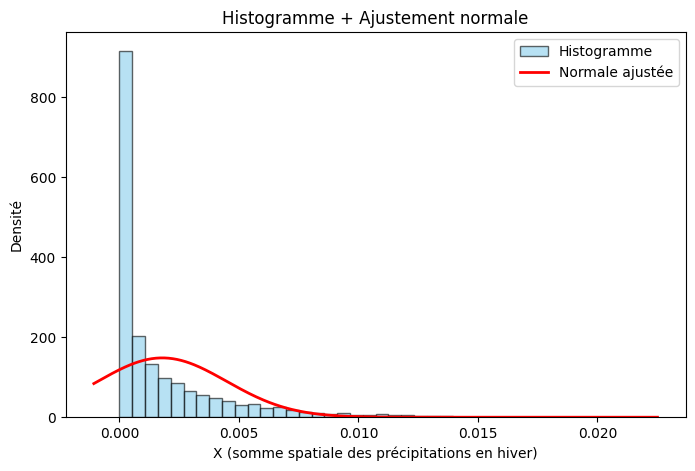

In [103]:
# Ajustement à la loi normale
mu, sigma = norm.fit(X)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(X, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)


On fait des tests statistiques: Shapiro-Wilk (spécialement pour Gaussienne) et Kolmogorov-Smirnov pour valider ou non la distribution.

In [104]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(X)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(X, 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

Test Shapiro-Wilk :
  statistique = 0.6938399466934104
  p-value     = 2.6007498140892887e-79 

Test KS (paramètres estimés) :
  statistique = 0.25268329868908956
  p-value     = 0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7550.
  res = hypotest_fun_out(*samples, **kwds)


**Principe du graphique Quantile-Quantile:**
+ *Axe Horizontal - Quantiles Théoriques:*
 Représente les quantiles théoriques de la distribution normale standard (ou de la distribution normale ajustée aux données).

+ *Axe Vertical - Quantiles réels :* Valeurs Ordonnées
 Représente les valeurs observées (ensemble de données), triées par ordre croissant.

Chaque point bleu représente une observation (ordonnée) et le quantile théorique correspondant (abscisse) ((ie) qu'il devrait avoir si les données suivaient parfaitement la loi normale ajustée).

Si les données suivaient parfaitement la loi normale, tous les points devraient se situer exactement sur la droite y=x, car les quantiles théoriques seraient égaux aux quantiles observés.



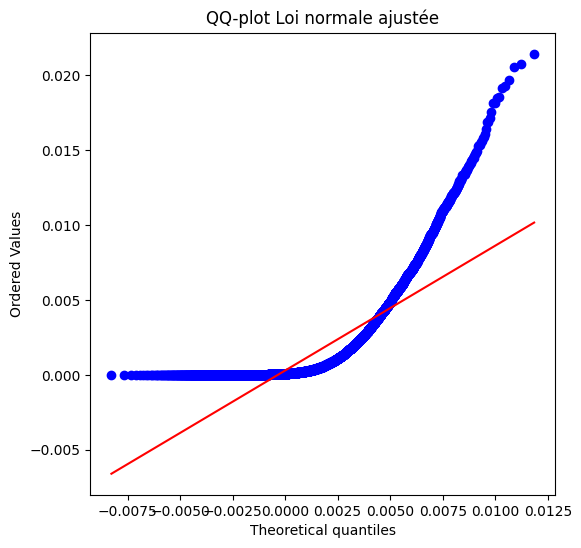

In [105]:
# Diagramme Quantile-Quantile de la normale
plt.figure(figsize=(6,6))
st.probplot(X, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

**Analyse du QQ-Plot de la normale**

Le QQ-plot montre un écart significatif par rapport à l'alignement parfait, indiquant que la distribution des données n'est pas normale :

+ Centre de la Distribution : les points suivent presque la droite, on a donc un comportement quasi-normale au centre.

+ Queue Gauche (Petites Valeurs) : Pas de valeurs négatives dans les précipitations alors que la loi normale centrée en µ (~145mm) en prévoit.

+ Queue Droite (Grandes Valeurs) : Les points bleus s'envolent au-dessus de la ligne rouge. Cela montre qu'il y a des valeurs extrêmes positives. Ces valeurs sont beaucoup plus élevées que ce qu'une distribution normale classique permettrait.

**Conclusion :** La distribution est fortement asymétrique et possède des queues plus épaisses que la distribution normale, ce qui invalide l'hypothèse de normalité pour cet ensemble de données.

### **2. Distribution Gamma**

Paramètres gamma : 0.3968706699626844 0.004597345
Log-vraisemblance maximale : 42540.06625075201
AIC = -85076.13250150402


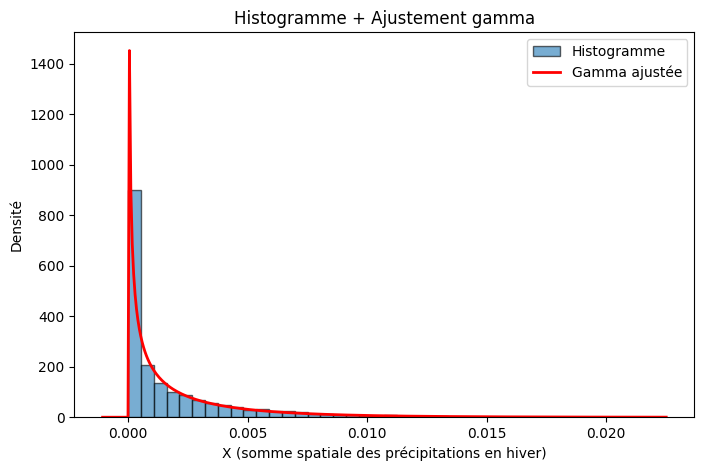

In [106]:
# Garder uniquement les valeurs strictement positives
X_pos = X[X > 0]

# Ajustement à la loi Gamma
alpha, loc, beta = gamma.fit(X_pos, floc=0)        # estimation des paramètres
print("Paramètres gamma :", alpha, beta)

# Histogramme + densité gamma ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X_pos, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")
# Log-vraisemblance
logL_gamma = np.sum(gamma.logpdf(X_pos, alpha, loc=0, scale=beta))
print("Log-vraisemblance maximale :", logL_gamma)

# AIC (k = 2 paramètres : alpha, beta)
AIC_gamma = 2*2 - 2*logL_gamma
print("AIC =", AIC_gamma)

# Courbe théorique gamma ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=beta),
         'r-', lw=2, label="Gamma ajustée")

plt.xlabel("X (somme spatiale des précipitations en hiver)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement gamma")
plt.legend()
plt.show()


Statistique KS : 0.025767462317725587
p-value : 0.00010434931882176886


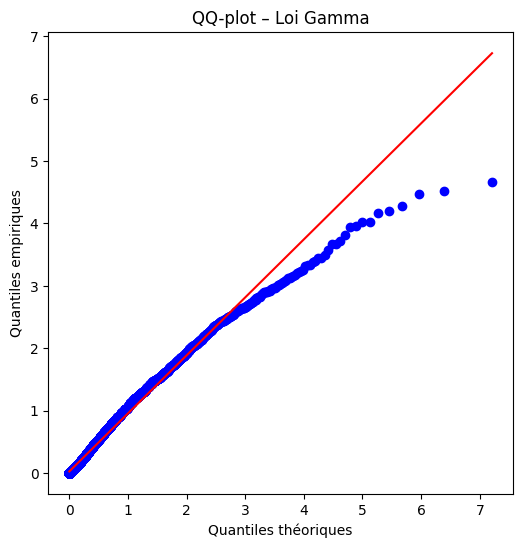

In [107]:
# Test de Kolmogorov–Smirnov pour la loi Gamma ajustée
D, p_value = kstest(X_pos, 'gamma', args=(alpha, 0, beta))

print("Statistique KS :", D)
print("p-value :", p_value)

# Données standardisées (enlever scale)
X_std = X_pos / beta

# QQ-plot Gamma (scale = 1)
plt.figure(figsize=(6,6))
probplot(X_std, dist=gamma, sparams=(alpha,), plot=plt)
plt.title("QQ-plot – Loi Gamma")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles empiriques")
plt.show()


Le QQ-plot montre un bon alignement des quantiles centraux, indiquant que la loi Gamma décrit correctement la partie principale des données.
En revanche, les écarts marqués dans la queue droite révèlent une sous-estimation des événements extrêmes, fréquente pour les précipitations intenses.

*Optionnel: On peut utiliser le bootstrap pour estimer les paramètres*

**Principe:** On veut estimer α (shape) et β (scale) de la loi Gamma pour les précipitations positives X_pos.
On fait un bootstrap : répéter 1000 fois
- tirer un échantillon aléatoire avec remise depuis X_pos
- ajuster une Gamma sur cet échantillon (gamma.fit)
stocker les paramètres estimés α et β

À la fin, on obtient 1000 valeurs de α et β → permet de mesurer l’incertitude sur ces paramètres.

In [108]:
# Bootstrap pour la loi Gamma: ré-échantillonner X_pos et ré-estimer les paramètres Gamma
# Paramètres
n_boot = 1000
alpha_boot = []
beta_boot = []

# Bootstrap
for _ in range(n_boot):
    Xb = np.random.choice(X_pos, size=len(X_pos), replace=True)  # ré-échantillonnage
    a, loc, b = gamma.fit(Xb, floc=0)                             # ajustement gamma
    alpha_boot.append(a)
    beta_boot.append(b)

alpha_boot = np.array(alpha_boot)
beta_boot = np.array(beta_boot)

In [109]:
# Intervalles de confiance (95 %)
alpha_ci = np.percentile(alpha_boot, [2.5, 97.5])
beta_ci  = np.percentile(beta_boot,  [2.5, 97.5])

print("IC 95% alpha :", alpha_ci)
print("IC 95% beta  :", beta_ci)

IC 95% alpha : [0.38797853 0.40715322]
IC 95% beta  : [0.00442452 0.00476601]


### **3. Distribution Beta**

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


Paramètres beta : 0.5157486289882971 108.18199751197416 -1.4202669262886049e-08 0.1258143190814579
Log-vraisemblance maximale : 40492.19688265005
AIC = -80976.3937653001


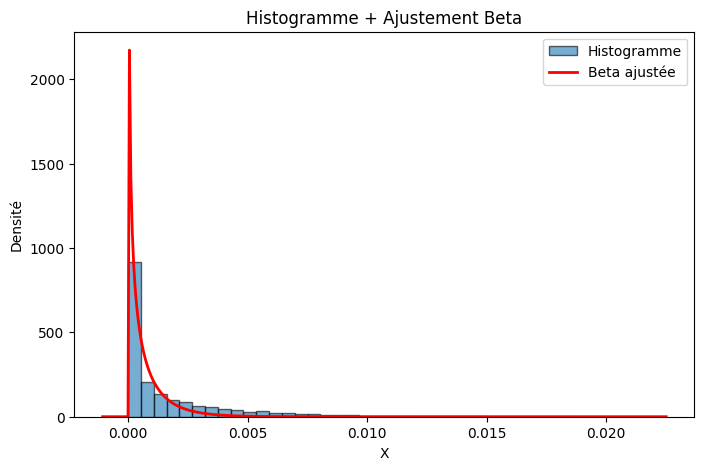

In [110]:
# Ajustement à la loi Beta (avec loc et scale libres)
a, b, loc, scale = beta_dist.fit(X)
print("Paramètres beta :", a, b, loc, scale)

# Histogramme + densité beta ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(X, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance
logL_beta = np.sum(beta_dist.logpdf(X, a, b, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL_beta)

# AIC (4 paramètres : a, b, loc, scale)
AIC_beta = 2*4 - 2*logL_beta
print("AIC =", AIC_beta)

# Courbe théorique beta ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc, scale=scale),
         'r-', lw=2, label="Beta ajustée")

plt.xlabel("X")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Beta")
plt.legend()
plt.show()


Statistique KS : 0.23005596312856236
p-value : 0.0


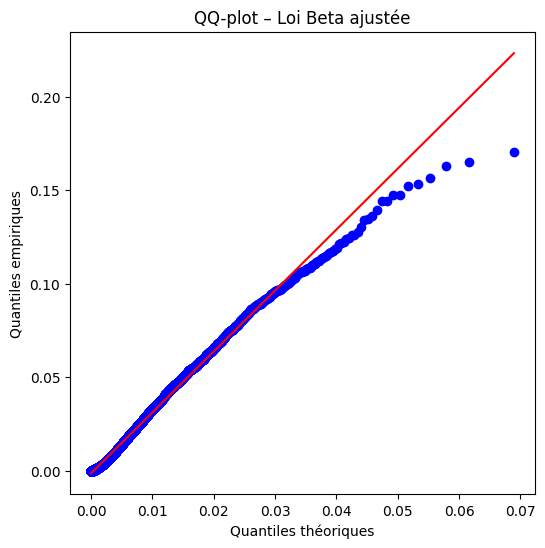

In [111]:
# Test KS pour la loi Beta ajustée
D, p_value = kstest(X, 'beta', args=(a, b, loc, scale))
print("Statistique KS :", D)
print("p-value :", p_value)

# Recentrage / rescaling sur [0,1]
X_std = (X - loc) / scale

# QQ-plot pour la loi Beta
plt.figure(figsize=(6,6))
probplot(X_std, dist=beta_dist, sparams=(a, b), plot=plt)
plt.title("QQ-plot – Loi Beta ajustée")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles empiriques")
plt.show()

Le QQ-plot montre un bon accord pour les quantiles centraux, ce qui indique que la loi Beta ajustée reproduit correctement la masse principale des données.
Les écarts visibles dans la queue droite traduisent toutefois une mauvaise représentation des valeurs extrêmes, confirmant les limites de ce modèle pour les fortes précipitations.

**On s'intéressera donc, ensuite, aux queues de distribution**

## **Etude des queues de distribution pour les précipitations**

### 1.Définition des variables:

On définit quatre variables :

1) **WinterPI :** la somme des précipitations sur tout l’hiver DJF (Décembre-Janvier-Février) en mm.

2) **Somme_mois :** la somme des précipitations pour chaque mois de l’hiver DJF en mm.

3) **pr_max_an :** la précipitation maximale observée sur un jour de chaque hiver (DJF), en mm.

4) **pr_max_mois :** la valeur maximale de précipitation enregistrée sur un jour pour chaque mois, exprimée en mm.

Toutes les variables sont calculées sur toutes la Bretagne (somme spatiale déjà faite dans X)  

In [112]:
# max par mois, on revient au dataset pour récuperer les mois et trouver les max
# Créer un DataArray 'year_month' correspondant à chaque date
year_month = xr.DataArray(
    ds_djf['time'].dt.year * 100 + ds_djf['time'].dt.month,  # format YYYYMM
    coords={'time': ds_djf['time']},
    dims='time'
)

# Maximum journalier par mois (somme spatiale)
pr_journalier = ds_djf['pr'].sum(dim=['Latitude', 'Longitude'])
pr_max_mois = pr_journalier.groupby(year_month).max() # c'est X en fait

print(pr_max_mois)
print("Nombre de mois :", len(pr_max_mois))

<xarray.DataArray 'pr' (group: 251)> Size: 2kB
array([ 850.22210693,  464.00061035,  769.93212891, 1794.25561523,
        762.63269043,  342.68154907,  726.21655273,  280.8661499 ,
        811.66296387, 1852.7076416 ,  680.73205566,  852.71234131,
        595.66345215,  221.47874451, 1219.31591797,  554.06787109,
        679.87481689,  637.32244873,  766.44244385,  605.54876709,
        913.55578613,  479.22958374,  570.29772949, 1202.86474609,
       1006.94665527,  264.10012817, 1100.08166504,  943.22351074,
        407.48916626,  551.35986328,  535.56384277, 1184.36584473,
        873.37786865,  719.40429688, 1286.73071289,  740.32434082,
        544.80169678,  301.42300415, 1117.35241699,  524.01141357,
        519.02960205,  298.78561401,  802.26483154,  721.10754395,
        832.33569336, 1196.89660645,  900.93670654,  650.94091797,
        959.52563477,  149.849823  ,  799.70690918,  254.70202637,
        993.44024658,  720.2076416 ,  839.91827393,  819.25274658,
        567.833

(251,)

In [166]:
# Somme journalière spatiale
somme_quotidienne_pr_djf = ds_djf['pr'].sum(dim=['Latitude', 'Longitude']) # c'est X en fait

# Somme totale par hiver
# on définit l'hiver en comptant: décembre de l'année i-1 et janvier, février de l'année i
annee_hiver = ds_djf['time.year'].where(ds_djf['time.month'] != 12, ds_djf['time.year'] + 1)
WinterPI = ds_djf['pr'].groupby(annee_hiver).sum(dim=['time', 'Latitude', 'Longitude'])
WinterPI = WinterPI.assign_coords(year=np.unique(annee_hiver.values))

# Somme mensuelle
Somme_mois = (
    ds_djf['pr']
    .sum(dim=['Latitude', 'Longitude'])  # somme spatiale
    .groupby(year_month)
    .sum(dim='time')                     # somme TEMPORELLE
)

# maximum par an
pr_max_an = ds_djf['pr'].sum(dim=['Latitude','Longitude']).groupby('time.year').max()

# Affichage final
print(annee_hiver)
print("WinterPI (somme d'un hiver DJF)", WinterPI)
print("Nombre d'hivers :", len(WinterPI))

print("Somme par mois (DJF)", Somme_mois)
print("Nombre de mois :", len(Somme_mois))

print("Max par mois (précipitation journalière max)",pr_max_an )
print("Nombre d'année :", len(pr_max_an))
pr_max_an.shape


<xarray.DataArray 'year' (time: 7550)> Size: 60kB
array([1940, 1940, 1940, ..., 2023, 2023, 2023])
Coordinates:
  * time     (time) datetime64[ns] 60kB 1940-01-01 1940-01-02 ... 2023-02-28
    height   float64 8B 0.0
WinterPI (somme d'un hiver DJF) <xarray.DataArray 'pr' (year: 84)> Size: 336B
array([ 8377.799 , 15172.459 ,  7901.8545, 16133.89  ,  6146.8125,
       11490.911 , 13386.957 , 11288.445 , 13297.986 , 12569.238 ,
       13358.568 , 17136.406 ,  9778.834 ,  9171.723 ,  8722.051 ,
       15582.819 , 11727.835 , 17879.463 , 15123.016 , 11449.756 ,
       18136.957 , 16163.619 , 14360.942 ,  8398.139 ,  6663.288 ,
       12529.6875, 20239.215 , 14259.468 , 11374.627 , 12065.504 ,
       15991.568 ,  9821.185 , 15085.014 ,  9259.478 , 17334.346 ,
        9132.387 ,  5769.491 , 17019.125 , 19609.29  , 24382.764 ,
       16323.769 ,  9715.227 , 18556.426 , 13831.113 , 15407.055 ,
       14046.289 , 16734.344 ,  9234.358 , 20176.715 ,  7646.9746,
       24017.86  , 12432.268 ,  396

(84,)

In [114]:
print(len(Somme_mois)) #vérification en regardant le nombre de mois pris en compte (normalement: 84*3-1=251)
print(len(Somme_mois))
np.unique(year_month)[:252]
np.unique(year_month)[-252:]

251
251


array([194001, 194002, 194012, 194101, 194102, 194112, 194201, 194202,
       194212, 194301, 194302, 194312, 194401, 194402, 194412, 194501,
       194502, 194512, 194601, 194602, 194612, 194701, 194702, 194712,
       194801, 194802, 194812, 194901, 194902, 194912, 195001, 195002,
       195012, 195101, 195102, 195112, 195201, 195202, 195212, 195301,
       195302, 195312, 195401, 195402, 195412, 195501, 195502, 195512,
       195601, 195602, 195612, 195701, 195702, 195712, 195801, 195802,
       195812, 195901, 195902, 195912, 196001, 196002, 196012, 196101,
       196102, 196112, 196201, 196202, 196212, 196301, 196302, 196312,
       196401, 196402, 196412, 196501, 196502, 196512, 196601, 196602,
       196612, 196701, 196702, 196712, 196801, 196802, 196812, 196901,
       196902, 196912, 197001, 197002, 197012, 197101, 197102, 197112,
       197201, 197202, 197212, 197301, 197302, 197312, 197401, 197402,
       197412, 197501, 197502, 197512, 197601, 197602, 197612, 197701,
      

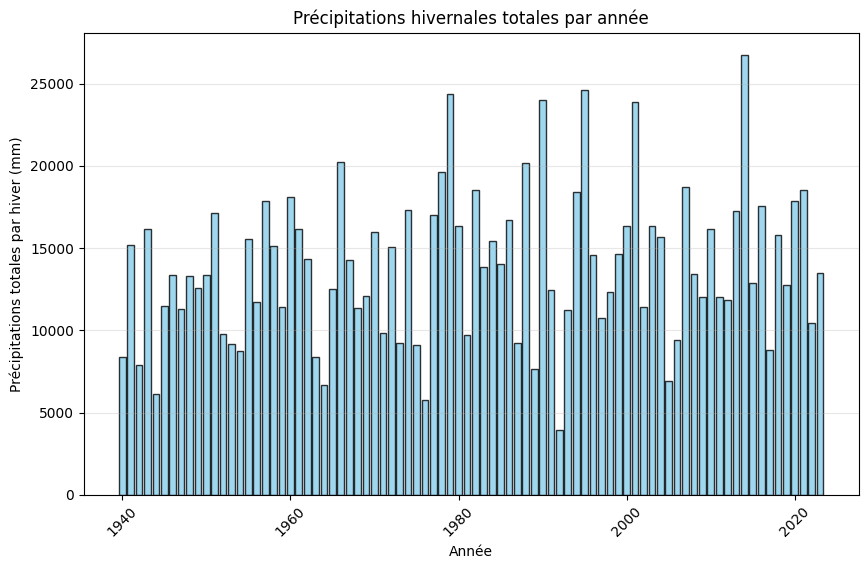

In [115]:
# Histogramme des précipitations par hiver pour chaque année
plt.figure(figsize=(10,6))
plt.bar(WinterPI.year, WinterPI.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Année")
plt.ylabel("Précipitations totales par hiver (mm)")
plt.title("Précipitations hivernales totales par année")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 2.GEV sur les maximums hivernaux de précipitation

On trace d'abord l'histogramme des maximums hivernaux et l'ajustement normal

mu: 1126.0542733328682 sigma: 283.6177077551074


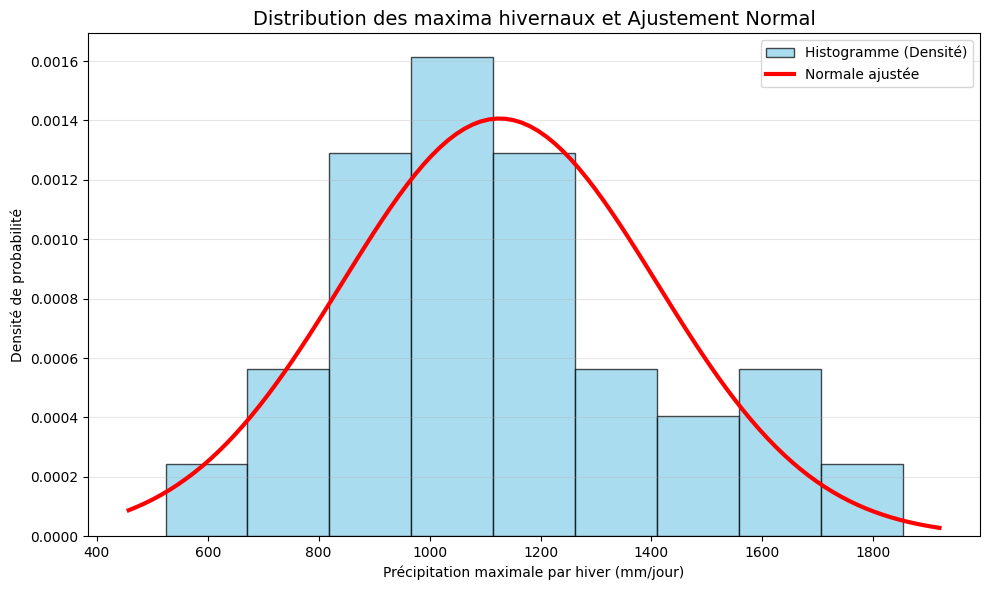

In [116]:
# Tracé de l'histogramme en densité
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (sqrt(N) ici) pour le pas de l'histogramme
bins = int(np.sqrt(len(pr_max_an.values)))

plt.hist(pr_max_an.values, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# Courbe normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)

mu, sigma = norm.fit(pr_max_an.values)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée')
print("mu:", mu, "sigma:", sigma)

# Labels et légende
plt.xlabel("Précipitation maximale par hiver (mm/jour)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution des maxima hivernaux et Ajustement Normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

On trace ensuite la GEV sur les max hivernaux (on définit les paramètres c1, loc1, scale1)

Paramètres GEV ajustés :
 c (shape) = 0.107, loc1 = 1006.42, scale1 = 246.88


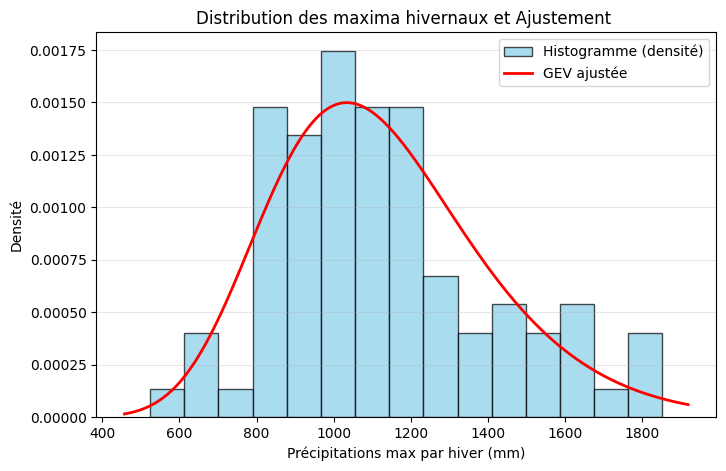

In [117]:
# Ajustement GEV
# genextreme utilise un paramètre c1 (shape), loc1 (location), scale1 (scale)
c1, loc1, scale1 = genextreme.fit(pr_max_an.values)
print(f"Paramètres GEV ajustés :\n c (shape) = {c1:.3f}, loc1 = {loc1:.2f}, scale1 = {scale1:.2f}")

# Histogramme en densité
plt.figure(figsize=(8,5))
plt.hist(pr_max_an.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c1, loc1, scale1), 'r-', lw=2, label='GEV ajustée')

# Labels et légende
plt.xlabel("Précipitations max par hiver (mm)")
plt.ylabel("Densité")
plt.title("Distribution des maxima hivernaux et Ajustement ")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()



**Lien avec le cours:**

ξ=c (paramètre de forme ou shape)

μ=loc (paramètre de position ou location)

σ=scale (paramètre d'échelle ou scale)

On calcule l'AIC et la p-value pour cette distribution.

In [118]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c1, loc1, scale1).cdf(x)

# KS-test
ks_stat, ks_p = kstest(WinterPI.values, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genextreme.logpdf(WinterPI.values, c1, loc1, scale1))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)



Test KS (GEV ajustée) :
  Statistique = 1.0
  p-value     = 0.0
Log-vraisemblance maximale : -inf
AIC = inf


**Raisons du Mauvais Ajustement**

On a trop peu de valeurs

### 3.GEV sur les maximums mensuels de précipitation

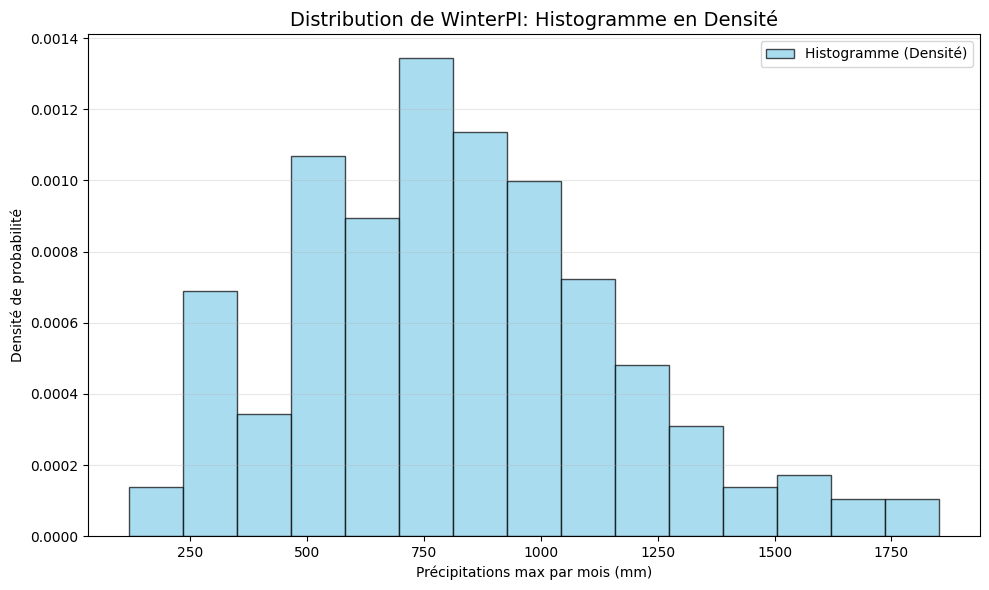

In [119]:
# Tracé de l'histogramme en densité
plt.figure(figsize=(10,6))
# Calculer le nombre de bins (souvent sqrt(N) ou formule de Freedman-Diaconis)
bins = int(np.sqrt(len(pr_max_mois)))

plt.hist(pr_max_mois, bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (Densité)')

# Labels et légende
plt.xlabel("Précipitations max par mois (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de WinterPI: Histogramme en Densité", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Paramètres GEV ajustés :
 c (shape) = -5.854, loc2 = 118.02, scale2 = 2.50


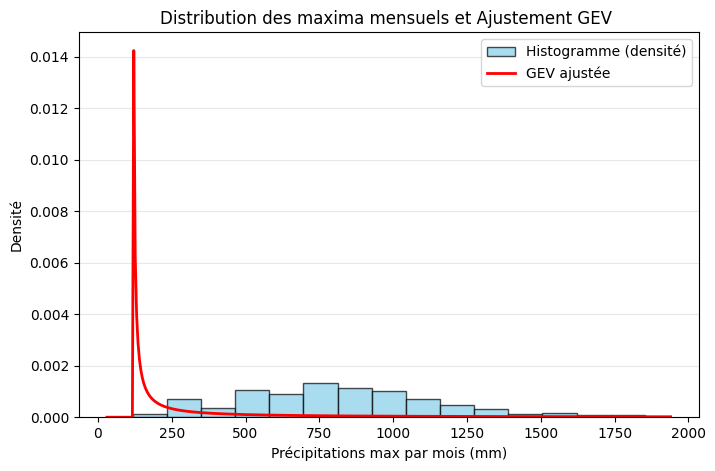

In [120]:
# Ajustement GEV
# genextreme utilise un paramètre c2 (shape), loc2 (location), scale2 (scale)
c2, loc2, scale2 = genextreme.fit(pr_max_mois)
print(f"Paramètres GEV ajustés :\n c (shape) = {c2:.3f}, loc2 = {loc2:.2f}, scale2 = {scale2:.2f}")

# Histogramme en densité
plt.figure(figsize=(8,5))
plt.hist(pr_max_mois.values, bins=15, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (densité)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, c2, loc2, scale2), 'r-', lw=2, label='GEV ajustée')

# Labels et légende
plt.xlabel("Précipitations max par mois (mm)")
plt.ylabel("Densité")
plt.title("Distribution des maxima mensuels et Ajustement GEV ")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [121]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(c2, loc2, scale2).cdf(x)

# KS-test
ks_stat, ks_p = kstest(pr_max_mois, gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

Test KS (GEV ajustée) :
  Statistique = 0.667732062613988
  p-value     = 8.481864978556284e-111


### 4.GPD sur le cumul hivernal de précipitation

nombre de valeurs prises en compte : 25


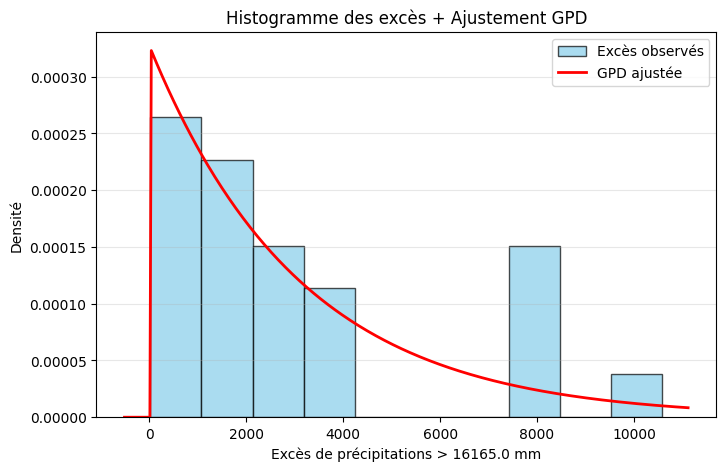

Paramètres GPD : shape(c)=-0.015, loc3=12.4, scale3=3070.9


In [167]:

# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(WinterPI.values, threshold)  # 70ème percentile
exceedances_W = WinterPI.values[WinterPI.values > seuil] - seuil  # excès au-dessus du seuil
print("nombre de valeurs prises en compte :", len(exceedances_W))
# 2. Ajuster la GPD aux excès
c3, loc3, scale3 = genpareto.fit(exceedances_W)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_W, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c3, loc3, scale3), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c3:.3f}, loc3={loc3:.1f}, scale3={scale3:.1f}")


In [123]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c3, loc3, scale3).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_W, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_W, c3, loc3, scale3))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.12264401154475968
  p-value     = 0.8030411135576355
Log-vraisemblance maximale : -225.36163823556
AIC = 456.72327647112


**Remarque**: on a peu de valeurs pourtant on a pris un seuil bas, donc on passe au cumul par mois

### 5.GPD sur le cumul mensuel de précipitation

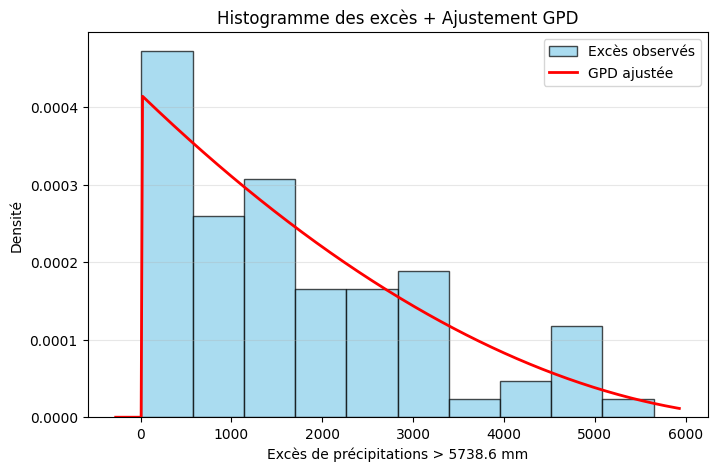

Paramètres GPD : shape(c)=-0.346, loc4=7.7, scale4=2408.0


In [124]:
# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(Somme_mois, threshold)  # 70ème percentile
exceedances_M = Somme_mois[Somme_mois > seuil] - seuil  # excès au-dessus du seuil

# 2. Ajuster la GPD aux excès
c4, loc4, scale4 = genpareto.fit(exceedances_M)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_M, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c4, loc4, scale4), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c4:.3f}, loc4={loc4:.1f}, scale4={scale4:.1f}")

In [125]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c4, loc4, scale4).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_M, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_M, c4, loc4, scale4))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.07893274556075619
  p-value     = 0.7083503912851086
Log-vraisemblance maximale : -633.0311948381282
AIC = 1272.0623896762563


Les valeurs sont satisfaisantes

### 6.GPD sur le cumul journalier de précipitation

Ici on traite X.

In [126]:
print("len(X) =", len(X))
print("min(X), max(X) =", np.nanmin(X), np.nanmax(X))

seuil = np.nanpercentile(X, threshold)
print("seuil =", seuil)

print("nb X > seuil =", np.sum(X > seuil))

len(X) = 7550
min(X), max(X) = -1.4202669e-08 0.021443373
seuil = 0.0018714062
nb X > seuil = <xarray.DataArray 'pr' ()> Size: 8B
array(2265)
Coordinates:
    height   float64 8B ...


Avec un seuil à 70%, on conserve 2265 jours.

Nombre d'excès : 2265


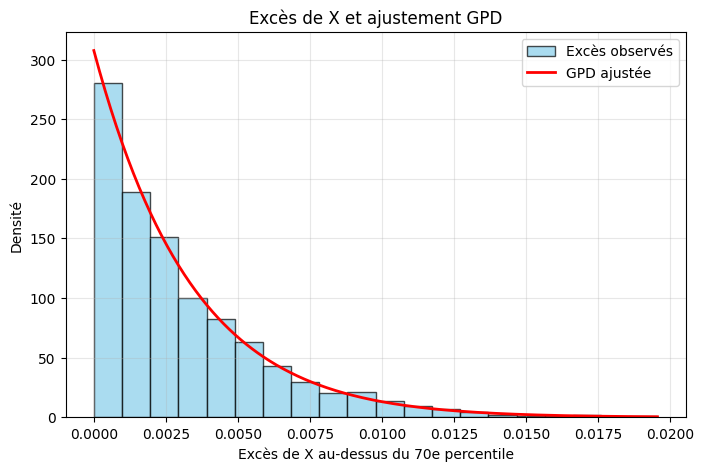

Paramètres GPD : shape=-0.045, scale=0.003


In [127]:
X_np = X.values

# Seuil
seuil = np.percentile(X_np, 70)

# Excès
exceedances_D = X_np[X_np > seuil] - seuil
print("Nombre d'excès :", len(exceedances_D))

# Ajustement GPD
c4, loc4, scale4 = genpareto.fit(exceedances_D, floc=0)

# Histogramme
plt.figure(figsize=(8,5))
plt.hist(exceedances_D, bins=20, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Excès observés')

# Courbe GPD
xx = np.linspace(0, exceedances_D.max(), 400)
plt.plot(xx, genpareto.pdf(xx, c4, loc=0, scale=scale4),
         'r-', lw=2, label='GPD ajustée')

plt.xlabel("Excès de X au-dessus du 70e percentile")
plt.ylabel("Densité")
plt.title("Histogramme excès de X et ajustement GPD")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Paramètres GPD : shape={c4:.3f}, scale={scale4:.3f}")


In [129]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c4, loc4, scale4).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_D, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_D, c4, loc4, scale4))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.01558059456862615
  p-value     = 0.6356210266997054
Log-vraisemblance maximale : 10811.75676496669
AIC = -21617.51352993338


## **Etude des vents (Y)**

### **1. Distribution normale**

Paramètres normale : 6.404704 2.435008
Log-vraisemblance maximale : -17432.108996604413
AIC = 34868.217993208826
Test Shapiro-Wilk :
  statistique = 0.9672969459683689
  p-value     = 2.9708778349767306e-38 

Test KS :
  statistique = 0.05665506752885069
  p-value     = 1.6627855320132638e-21


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7550.
  res = hypotest_fun_out(*samples, **kwds)


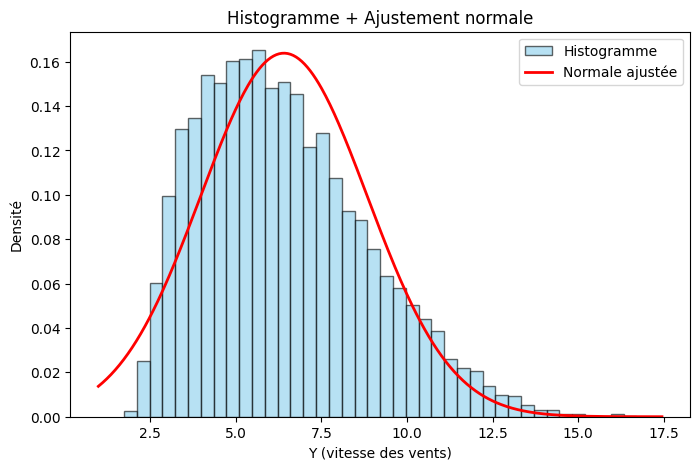

In [130]:
# Pour Y
# Ajustement à la loi normale
mu, sigma = norm.fit(Y)
print("Paramètres normale :", mu, sigma)

# Histogramme + densité normale ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6, color='skyblue',
         edgecolor='black', label="Histogramme")

# Courbe théorique normale ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=2, label="Normale ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement normale")
plt.legend()

# Log-vraisemblance
logL = np.sum(norm.logpdf(Y, mu, sigma))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 2 paramètres : mu, sigma)
AIC_norm = 2*2 - 2*logL
print("AIC =", AIC_norm)

# ------ Shapiro-Wilk ------
shapiro_stat, shapiro_p = shapiro(Y)
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# ------ KS (Kolmogorov-Smirnov) ------
ks_stat, ks_p = kstest(Y, 'norm', args=(mu, sigma))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)


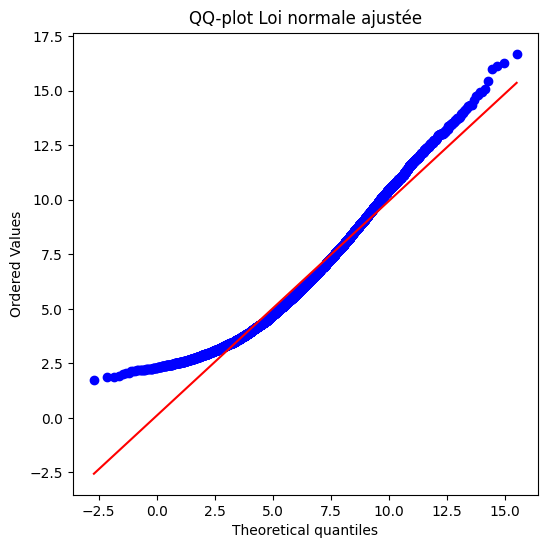

In [131]:
# Diagramme Quantile-Quantile de la noramle
plt.figure(figsize=(6,6))
st.probplot(Y, dist=norm, sparams=(mu, sigma), plot=plt)
plt.title("QQ-plot Loi normale ajustée")
plt.show()

Le QQ-plot montre un écart systématique à la droite, indiquant que la loi normale ne décrit pas correctement la distribution des vitesses de vent.
Les déviations marquées aux extrémités révèlent une asymétrie et des queues mal représentées par le modèle normal.

### **2. Distribution Gamma**

Paramètres gamma : 6.958205547890324 0.004597345
Log-vraisemblance maximale : -10204239.841722619
AIC = 20408483.683445238
Test KS :
  statistique = 1.0
  p-value     = 0.0


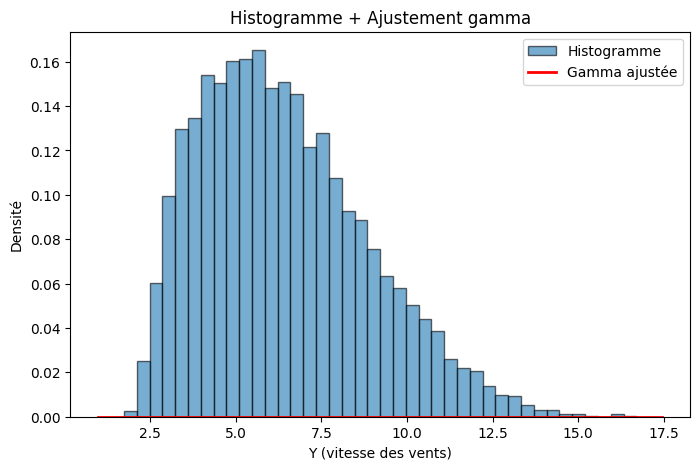

In [173]:
Y_pos = Y[Y > 0]

# Ajustement à la loi Gamma
alpha, loc, scale_gamma = gamma.fit(Y_pos, floc=0)
print("Paramètres gamma :", alpha, beta)

# Histogramme + densité gamma ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y_pos, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance
logL_gamma = np.sum(gamma.logpdf(Y_pos, alpha, loc=0, scale=beta))
print("Log-vraisemblance maximale :", logL_gamma)

# AIC (k = 2 paramètres : alpha, beta)
AIC_gamma = 2*2 - 2*logL_gamma
print("AIC =", AIC_gamma)

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(Y_pos, 'gamma', args=(alpha, 0, beta))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Courbe théorique gamma ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=beta),
         'r-', lw=2, label="Gamma ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement gamma")
plt.legend()
plt.show()

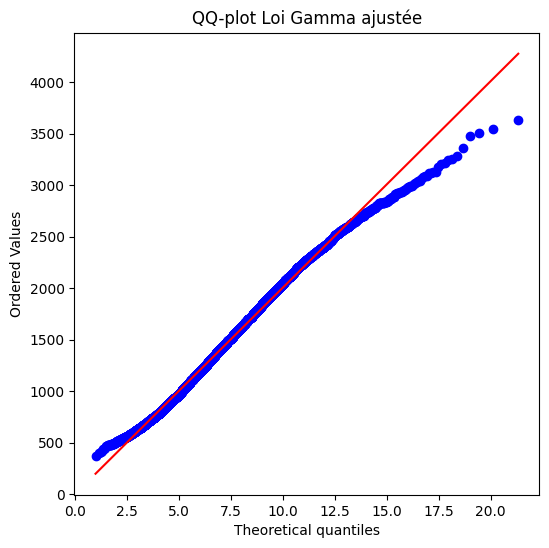

In [133]:
# Diagramme Quantile-Quantile de la loi Gamma
plt.figure(figsize=(6,6))

# Données standardisées (enlever scale)
Y_std = Y_pos / beta

st.probplot(Y_std, dist=gamma, sparams=(alpha,), plot=plt)

plt.title("QQ-plot Loi Gamma ajustée")
plt.show()

Le QQ-plot montre un bon alignement des quantiles centraux, indiquant que la loi Gamma décrit correctement la distribution des vitesses de vent.
Les écarts observés dans la queue droite suggèrent toutefois une légère sous-estimation des valeurs de vent les plus élevées.

### **3. Distribution Beta**

Paramètres beta : 2.5998714817204203 8.020162750398065 1.7112824615289306 19.179872124456743
Log-vraisemblance maximale : -16938.48245874719
AIC = 33884.96491749438
Test KS :
  statistique = 0.012781828090994984
  p-value     = 0.1681412946975085


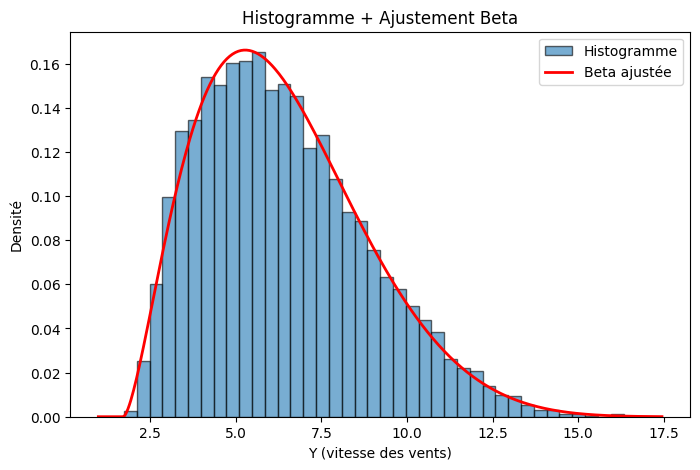

In [134]:
# Ajustement à la loi Beta
a, b, loc, scale = beta_dist.fit(Y)
print("Paramètres beta :", a, b, loc, scale)

# Histogramme + densité beta ajustée
plt.figure(figsize=(8,5))

# Histogramme
plt.hist(Y, bins=40, density=True, alpha=0.6,
         edgecolor='black', label="Histogramme")

# Log-vraisemblance (UTILISER beta_dist, pas beta)
logL_beta = np.sum(beta_dist.logpdf(Y, a, b, loc=loc, scale=scale))
print("Log-vraisemblance maximale :", logL_beta)

# AIC : 4 paramètres (a, b, loc, scale)
AIC_beta = 2*4 - 2*logL_beta
print("AIC =", AIC_beta)

# KS (Kolmogorov–Smirnov)
ks_stat, ks_p = kstest(Y, 'beta', args=(a, b, loc, scale))
print("Test KS :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Courbe théorique beta ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc, scale=scale),
         'r-', lw=2, label="Beta ajustée")

plt.xlabel("Y (vitesse des vents)")
plt.ylabel("Densité")
plt.title("Histogramme + Ajustement Beta")
plt.legend()
plt.show()


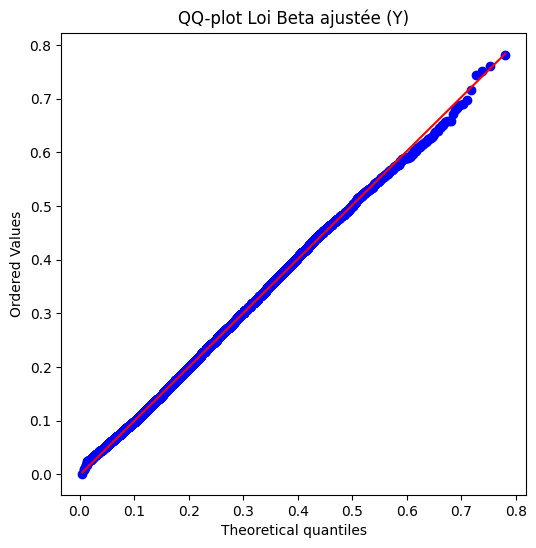

In [135]:
# Recentrer / re-scaler Y pour revenir sur [0,1]
Y_std = (Y - loc) / scale

# QQ-plot Beta avec probplot
plt.figure(figsize=(6,6))
st.probplot(Y_std, dist=beta_dist, sparams=(a, b), plot=plt)
plt.title("QQ-plot Loi Beta ajustée (Y)")
plt.show()

Le QQ-plot montre un très bon alignement sur l’ensemble des quantiles, indiquant que la loi Beta ajustée décrit bien la distribution des vitesses de vent.
Les légers écarts en queue droite restent faibles et suggèrent un ajustement globalement satisfaisant, meilleur que celui de la loi normale.

### **4. GPD pour Y: moyenne de vent journalière**

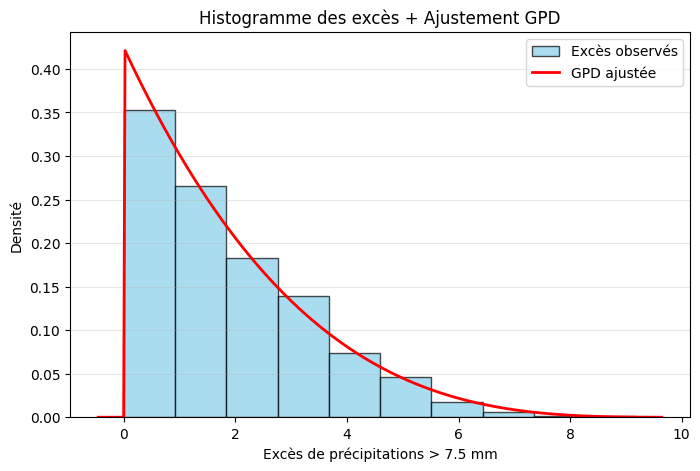

Paramètres GPD : shape(c)=-0.236, loc5=1.7, scale5=2.4


In [136]:
# 1. Choisir un seuil pour les extrêmes
seuil = np.percentile(Y, threshold)  # 70ème percentile
exceedances_YD = Y[Y > seuil] - seuil  # excès au-dessus du seuil

# 2. Ajuster la GPD aux excès
c5, loc5, scale5 = genpareto.fit(exceedances_YD)

# 3. Histogramme des excès (densité)
plt.figure(figsize=(8,5))
plt.hist(exceedances_YD, bins=10, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Excès observés')

# 4. Courbe GPD ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genpareto.pdf(xx, c5, loc5, scale5), 'r-', lw=2, label='GPD ajustée')

# 5. Labels et légende
plt.xlabel(f"Excès de précipitations > {seuil:.1f} mm")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Affichage des paramètres
print(f"Paramètres GPD : shape(c)={c5:.3f}, loc5={loc:.1f}, scale5={scale5:.1f}")

In [137]:
# Construction de la  paramétrée
gpd_cdf = lambda x: genpareto(c5, loc5, scale5).cdf(x)

# KS-test
ks_stat, ks_p = kstest(exceedances_YD, gpd_cdf)

print("Test KS (GPD ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# Log-vraisemblance
logL = np.sum(genpareto.logpdf(exceedances_YD, c5, loc5, scale5))
print("Log-vraisemblance maximale :", logL)

# AIC = 2k - 2 logL pour la normale (k = 3)
AIC_norm = 2*3 - 2*logL
print("AIC =", AIC_norm)

Test KS (GPD ajustée) :
  Statistique = 0.014511216902931279
  p-value     = 0.7210619929371442
Log-vraisemblance maximale : -3666.465515029594
AIC = 7338.931030059188


## **Etude des queues de distribution pour les vents**

### 1.Définition des variables:

In [174]:
# Grouper par année et par mois
Y_max = Y.groupby('time.year').map(lambda x: x.groupby('time.month').max(dim='time'))
print(Y_max.sizes)
print(Y_max.sizes)
print(Y_max.shape)
print(len(Y_max['year']))
print(len(Y_max['month']))

# Transformer en numpy array (shape = nb_annees × 3)
Y_max_values = np.array([x.values for x in Y_max])
print("Shape avant flatten :", Y_max_values.shape)

# Identifiant année–mois réel
year_month = Y['time'].dt.year * 100 + Y['time'].dt.month

# Max mensuel du vent (DJF)
Y_max_month = (
    Y
    .groupby(year_month)
    .max(dim='time')
)

print("La taille de Y_max_month est: ", len(Y_max_month))  # = 251 (comme Somme_mois)

# Affichage
print(Y_max_month)
print(len(Y_max_month))


Frozen({'year': 84, 'month': 3})
Frozen({'year': 84, 'month': 3})
(84, 3)
84
3
Shape avant flatten : (84, 3)
La taille de Y_max_month est:  251
<xarray.DataArray 'sfcWind' (group: 251)> Size: 2kB
array([ 7.83476019, 10.09995174, 11.20478725, 11.36468315, 13.50259209,
       11.81658554, 12.40323544,  8.05217934,  9.75095367, 14.13482189,
       10.60959911, 11.50073338, 10.40312099,  9.174263  , 11.91625309,
       11.89690304, 11.68322372, 11.62458229, 12.69151115, 12.29220486,
       11.75441837,  8.58282757,  7.65015554, 11.08776093, 11.05125523,
        9.63924217, 11.00717258, 13.68508339, 12.07698059,  9.69643879,
        7.81553125, 12.58375168, 10.14964485, 11.85835171, 14.196702  ,
       13.02904987, 12.18385696,  9.53630257, 11.44875908, 10.08596992,
       12.15663052,  7.80696297, 10.04051399, 10.71097279, 11.79619408,
       12.22029114, 11.93211174, 12.85323143,  9.89169025,  9.5182848 ,
       10.98441601,  9.88213634, 11.21700287, 10.84153938, 11.98259163,
       11.10

In [139]:
# Création d’un identifiant année–mois (YYYYMM) pour chaque date
year_month = xr.DataArray(
    ds_djf['time'].dt.year * 100 + ds_djf['time'].dt.month,
    coords={'time': ds_djf['time']},
    dims='time'
)

# Regroupement des moyenness de vitesse de vent par mois (année–mois)
Y_moy_mois = Y.groupby(year_month)

print(Y_moy_mois)        # affiche l’objet groupby
print(len(Y_moy_mois))   # nombre de mois DJF distincts


<DataArrayGroupBy, grouped over 1 grouper(s), 251 groups in total:
    'group': UniqueGrouper('group'), 251/251 groups with labels 194001, 194002, ..., 202302>
251


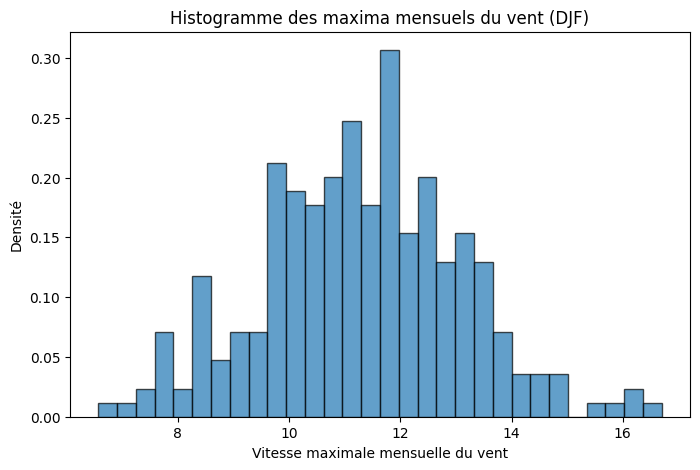

In [140]:
# Histogramme des maxima mensuels du vent (DJF)
plt.figure(figsize=(8,5))

plt.hist(Y_max_month, bins=30, density=True,
         edgecolor='black', alpha=0.7)

plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité")
plt.title("Histogramme des maxima mensuels du vent (DJF)")
plt.show()


### 2.Normale max mensuel

Test Shapiro-Wilk :
  statistique = 0.9951918799154564
  p-value     = 0.6249944702885792 

Test KS (paramètres estimés) :
  statistique = 0.02782449208775295
  p-value     = 0.9874416399519409


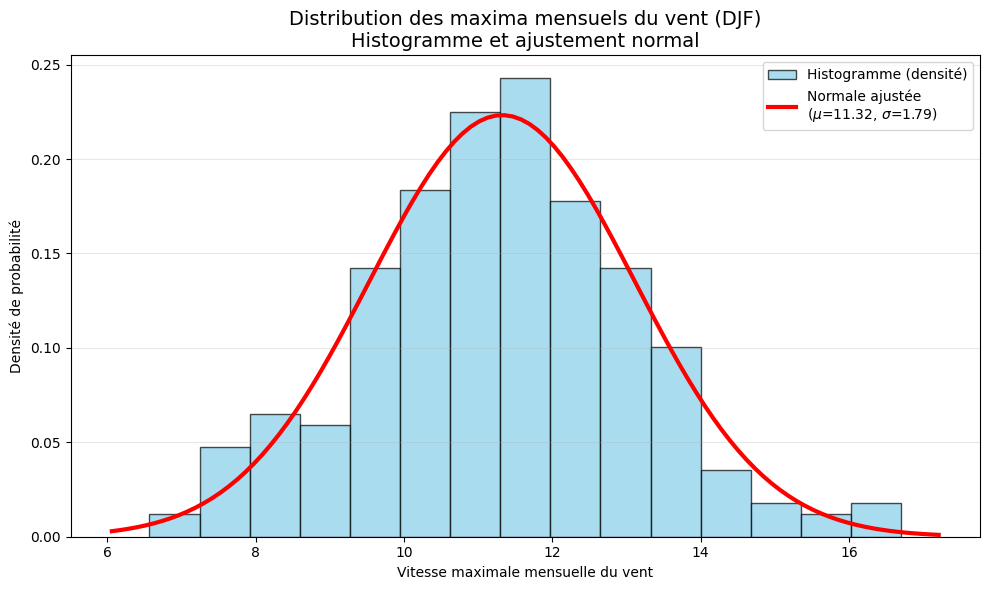

In [141]:
# Tracé de l'histogramme en densité des maxima mensuels du vent
plt.figure(figsize=(10,6))

# Nombre de bins
bins = int(np.sqrt(len(Y_max_month[:-1])))

plt.hist(Y_max_month[:-1], bins=bins, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Histogramme (densité)')

# Ajustement à la loi normale
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 100)
mu, sigma = norm.fit(Y_max_month[:-1])

plt.plot(xx, norm.pdf(xx, mu, sigma), 'r-', lw=3,
         label=f'Normale ajustée\n($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')

# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(Y_max_month[:-1])
print("Test Shapiro-Wilk :")
print("  statistique =", shapiro_stat)
print("  p-value     =", shapiro_p, "\n")

# KS (Kolmogorov-Smirnov)
ks_stat, ks_p = kstest(Y_max_month[:-1], 'norm', args=(mu, sigma))
print("Test KS (paramètres estimés) :")
print("  statistique =", ks_stat)
print("  p-value     =", ks_p)

# Labels et mise en forme
plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité de probabilité")
plt.title("Distribution des maxima mensuels du vent (DJF)\nHistogramme et ajustement normal", fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 3.Gamma et Beta pour max vent mensuel

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


 Gamma 
alpha = 39.00003031192499
scale = 0.29033692868128536
KS p-value = 0.6135571590406756

 Beta 
a = 465.30029243533454  b = 9981221.920106808
loc = -27.26499203092026  scale = 827795.100235007
KS p-value = 0.9296000101482544


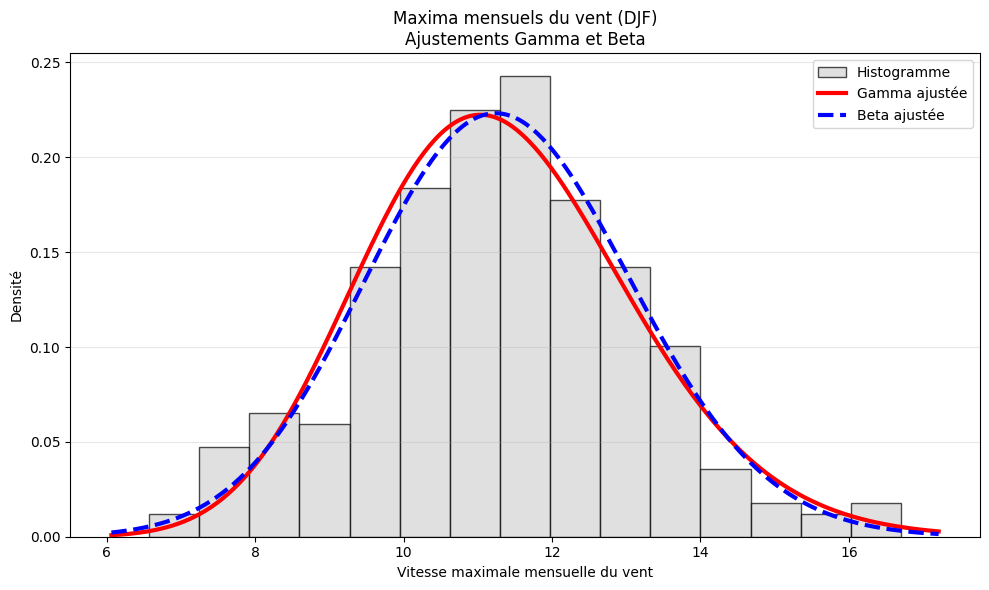

In [142]:
# Données : maxima mensuels du vent
Z = Y_max_month[:-1]   # on enlève la dernière si besoin

# Histogramme
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(Z)))

plt.hist(Z, bins=bins, density=True,
         color='lightgrey', edgecolor='black', alpha=0.7,
         label='Histogramme')

xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 300)

# GAMMA
Z_pos = Z[Z > 0]                           # Gamma → valeurs positives
alpha, loc_g, scale_g = gamma.fit(Z_pos, floc=0)

plt.plot(xx, gamma.pdf(xx, alpha, loc=0, scale=scale_g),
         'r-', lw=3, label='Gamma ajustée')

# p-value KS Gamma
ks_g, p_g = kstest(Z_pos, 'gamma', args=(alpha, 0, scale_g))

# BETA
a, b, loc_b, scale_b = beta_dist.fit(Z)

plt.plot(xx, beta_dist.pdf(xx, a, b, loc=loc_b, scale=scale_b),
         'b--', lw=3, label='Beta ajustée')

# p-value KS Beta
ks_b, p_b = kstest(Z, 'beta', args=(a, b, loc_b, scale_b))

# Résultats statistiques
print(" Gamma ")
print("alpha =", alpha)
print("scale =", scale_g)
print("KS p-value =", p_g)

print("\n Beta ")
print("a =", a, " b =", b)
print("loc =", loc_b, " scale =", scale_b)
print("KS p-value =", p_b)
# Plot final
plt.xlabel("Vitesse maximale mensuelle du vent")
plt.ylabel("Densité")
plt.title("Maxima mensuels du vent (DJF)\nAjustements Gamma et Beta")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.GEV max vent mensuel

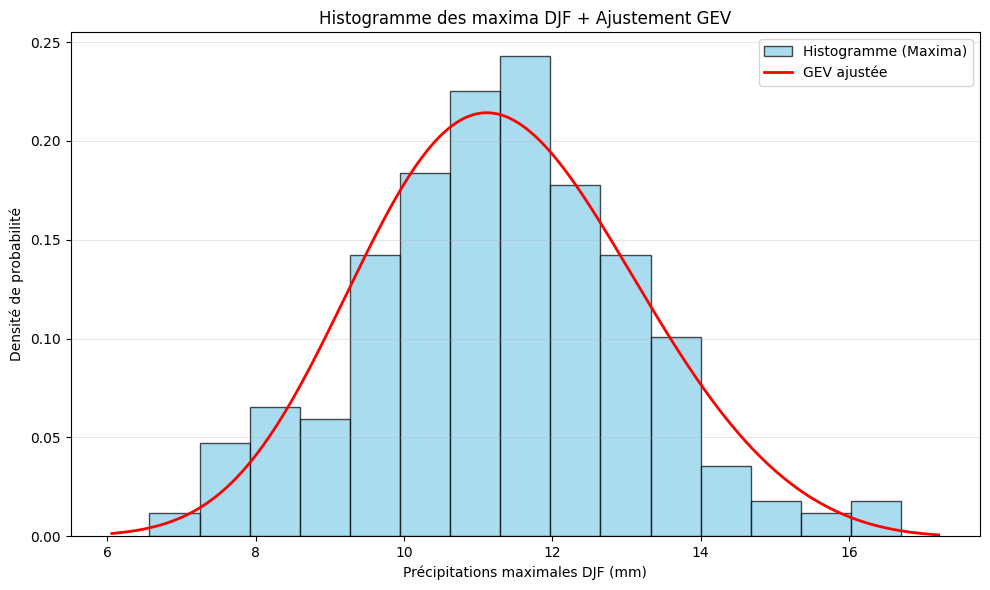

Paramètres GEV : shape(c)=0.237, loc=10.7, scale=1.8


In [176]:
# Ajustement GEV
cw1, locw1, scalew1 = genextreme.fit(Y_max_month[:-1])

# Histogramme des maxima
plt.figure(figsize=(10,6))
bins = int(np.sqrt(len(Y_max_month[:-1])))
plt.hist(Y_max_month[:-1], bins=bins, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme (Maxima)')

# Courbe GEV ajustée
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 400)
plt.plot(xx, genextreme.pdf(xx, cw1, locw1, scalew1), 'r-', lw=2, label='GEV ajustée')

plt.xlabel("Précipitations maximales DJF (mm)")
plt.ylabel("Densité de probabilité")
plt.title("Histogramme des maxima DJF + Ajustement GEV")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Paramètres GEV
print(f"Paramètres GEV : shape(c)={cw1:.3f}, loc={locw1:.1f}, scale={scalew1:.1f}")


In [177]:
# Construction de la CDF paramétrée
gev_cdf = lambda x: genextreme(cw1, loc=locw1, scale=scalew1).cdf(x)

# KS-test
ks_stat, ks_p = kstest(Y_max_month[:-1], gev_cdf)

print("Test KS (GEV ajustée) :")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

Test KS (GEV ajustée) :
  Statistique = 0.03485546255034422
  p-value     = 0.9111305273562189


### 5.GPD sur les moyennes de vent mensuelles

In [145]:
# Moyenne par mois (année–mois)
Y_moy_mois_val = Y.groupby(year_month).mean()

# Maintenant c’est un DataArray 1D
print(Y_moy_mois_val.shape)

(251,)


Nombre d'excès : 75


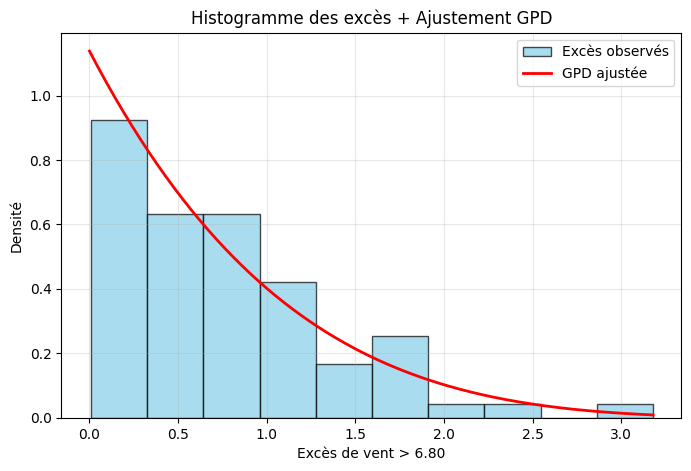

Test KS (GPD ajustée)
  Statistique = 0.07133343896091132
  p-value     = 0.813733582127118
Log-vraisemblance = -51.40203815166428
AIC GPD = 106.80407630332856
Paramètres GPD : shape=-0.185, scale=0.879


In [178]:
# 1. Seuil (70e percentile)
Y_np = np.asarray(Y_moy_mois_val)
Y_np = Y_np[np.isfinite(Y_np)]

seuil = np.percentile(Y_np, threshold)

# Excès
exceedances_YM = Y_np[Y_np > seuil] - seuil
print("Nombre d'excès :", len(exceedances_YM))

# 2. Ajustement GPD
c5, loc5, scale5 = genpareto.fit(exceedances_YM, floc=0)

# 3. Histogramme + GPD
plt.figure(figsize=(8,5))
plt.hist(exceedances_YM, bins=10, density=True,
         color='skyblue', edgecolor='black', alpha=0.7,
         label='Excès observés')

xx = np.linspace(0, exceedances_YM.max(), 400)
plt.plot(xx, genpareto.pdf(xx, c5, loc=0, scale=scale5),
         'r-', lw=2, label='GPD ajustée')

plt.xlabel(f"Excès de vent > {seuil:.2f}")
plt.ylabel("Densité")
plt.title("Histogramme des excès + Ajustement GPD")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. Test KS
ks_stat, ks_p = kstest(
    exceedances_YM,
    lambda x: genpareto.cdf(x, c5, loc=0, scale=scale5)
)

print("Test KS (GPD ajustée)")
print("  Statistique =", ks_stat)
print("  p-value     =", ks_p)

# 5. Log-vraisemblance et AIC
logL = np.sum(genpareto.logpdf(exceedances_YM, c5, loc=0, scale=scale5))
AIC_gpd = 2*2 - 2*logL   # k = 2 (shape + scale, loc fixé)

print("Log-vraisemblance =", logL)
print("AIC GPD =", AIC_gpd)

# 6. Paramètres
print(f"Paramètres GPD : shape={c5:.3f}, scale={scale5:.3f}")


##**Tableau recapitulatif des tests => Valider distribution**

In [179]:
import numpy as np
from scipy.stats import norm, gamma, beta as beta_dist, shapiro, kstest
from scipy.stats import genextreme, genpareto

def test_distributions(data, var_name, gpd_threshold=None):
    results = []

    data = np.asarray(data)
    data = data[np.isfinite(data)]

    # Normale
    mu, sigma = norm.fit(data)
    logL = np.sum(norm.logpdf(data, mu, sigma))
    AIC = 2*2 - 2*logL

    ks_stat, ks_p = kstest(data, 'norm', args=(mu, sigma))
    sh_stat, sh_p = shapiro(data[:5000])

    results.append([var_name, "Normale", ks_p, sh_p, AIC])

    # Gamma (positives)
    data_pos = data[data > 0]
    a, loc, scale = gamma.fit(data_pos, floc=0)
    logL = np.sum(gamma.logpdf(data_pos, a, 0, scale))
    AIC = 2*2 - 2*logL

    ks_stat, ks_p = kstest(data_pos, 'gamma', args=(a, 0, scale))

    results.append([var_name, "Gamma", ks_p, None, AIC])

    # Beta
    a, b, loc, scale = beta_dist.fit(data)
    logL = np.sum(beta_dist.logpdf(data, a, b, loc, scale))
    AIC = 2*4 - 2*logL   # a, b, loc, scale

    ks_stat, ks_p = kstest(data, 'beta', args=(a, b, loc, scale))

    results.append([var_name, "Beta", ks_p, None, AIC])

    # GEV (pour maxima)
    c, loc, scale = genextreme.fit(data)
    logL = np.sum(genextreme.logpdf(data, c, loc, scale))
    AIC = 2*3 - 2*logL

    ks_stat, ks_p = kstest(data, 'genextreme', args=(c, loc, scale))

    results.append([var_name, "GEV", ks_p, None, AIC])

    # GPD (POT)
    if gpd_threshold is not None:
        exceedances = data[data > gpd_threshold] - gpd_threshold

        if len(exceedances) > 20:  # sécurité
            c, loc, scale = genpareto.fit(exceedances, floc=0)
            logL = np.sum(genpareto.logpdf(exceedances, c, 0, scale))
            AIC = 2*2 - 2*logL

            ks_stat, ks_p = kstest(exceedances, 'genpareto', args=(c, 0, scale))

            results.append([var_name, "GPD", ks_p, None, AIC])

    return results


In [180]:
table_results = []

table_results += test_distributions(
    X,
    "Précipitations journalières DJF (X)",
    gpd_threshold=np.percentile(X, threshold)
)

table_results += test_distributions(
    Somme_mois,
    "Précipitations mensuelles DJF (Somme)",
    gpd_threshold=np.percentile(Somme_mois, threshold)
)

table_results += test_distributions(
    WinterPI,
    "Précipitations hivernales DJF (WPI)",
    gpd_threshold=np.percentile(WinterPI, threshold)
)

table_results += test_distributions(
    Y,
    "Vent moyen journalier DJF (Y)",
    gpd_threshold=np.percentile(Y, threshold)
)

table_results += test_distributions(
    Y_max_month,
    "Vent maximal mensuel DJF",
    gpd_threshold=np.percentile(Y_max_month, threshold)
)


/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:796: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:801: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


In [181]:
import pandas as pd

df_results = pd.DataFrame(
    table_results,
    columns=["Variable", "Loi", "KS p-value", "Shapiro p-value", "AIC"]
)

df_results


,Variable,Loi,KS p-value,Shapiro p-value,AIC
0,Précipitations journalières DJF (X),Normale,0.000000e+00,3.562874e-70,-67939.369852
1,Précipitations journalières DJF (X),Gamma,1.043493e-04,NaN,-85076.132502
2,Précipitations journalières DJF (X),Beta,0.000000e+00,NaN,-80976.393765
3,Précipitations journalières DJF (X),GEV,2.762502e-132,NaN,-81526.861067
4,Précipitations journalières DJF (X),GPD,6.356210e-01,NaN,-21619.513530
5,Précipitations mensuelles DJF (Somme),Normale,1.273054e-01,9.660940e-05,4608.384388
6,Précipitations mensuelles DJF (Somme),Gamma,4.608138e-01,NaN,4591.451269
7,Précipitations mensuelles DJF (Somme),Beta,9.795036e-01,NaN,4586.874751
8,Précipitations mensuelles DJF (Somme),GEV,3.443246e-124,NaN,5838.587932
9,Précipitations mensuelles DJF (Somme),GPD,7.361889e-01,NaN,1270.537281


# **IV/ Etude multivariée**

## Etude de la dépendance X-Y

### 1.Tracé du nuage de points des précipitations et des vents journaliers

In [150]:
# 1. Alignement des données (Sécurité pour s'assurer que les dates correspondent)
# On convertit les DataArrays X et Y en Séries Pandas indexées par le temps
df_X = X.to_dataframe(name='precip').reset_index().set_index('time')['precip']
df_Y = Y.to_dataframe(name='wind').reset_index().set_index('time')['wind']

# On joint les deux séries sur l'index temporel (intersection des dates)
df_joint = pd.concat([df_X, df_Y], axis=1, join='inner').dropna()

# Définition des vecteurs alignés
X_joint = df_joint['precip'].values
Y_joint = df_joint['wind'].values

print(f"Tous les jours sont conservés : {len(df_joint)==7550}")
print(df_X)
print(df_joint)
print(X_joint)

Tous les jours sont conservés : True
time
1940-01-01    2.753976e-07
1940-01-02    0.000000e+00
1940-01-03    3.913162e-03
1940-01-04    1.510238e-03
1940-01-05    1.526111e-04
                  ...     
2023-02-24    5.568967e-04
2023-02-25    1.368562e-04
2023-02-26    1.377269e-05
2023-02-27    2.468573e-05
2023-02-28    2.168384e-03
Name: precip, Length: 7550, dtype: float32
                  precip      wind
time                              
1940-01-01  2.753976e-07  7.834760
1940-01-02  0.000000e+00  7.027803
1940-01-03  3.913162e-03  6.503153
1940-01-04  1.510238e-03  4.614581
1940-01-05  1.526111e-04  3.163189
...                  ...       ...
2023-02-24  5.568967e-04  7.247035
2023-02-25  1.368562e-04  6.912128
2023-02-26  1.377269e-05  8.036705
2023-02-27  2.468573e-05  7.903212
2023-02-28  2.168384e-03  7.378880

[7550 rows x 2 columns]
[2.7539758e-07 0.0000000e+00 3.9131618e-03 ... 1.3772695e-05 2.4685731e-05
 2.1683841e-03]


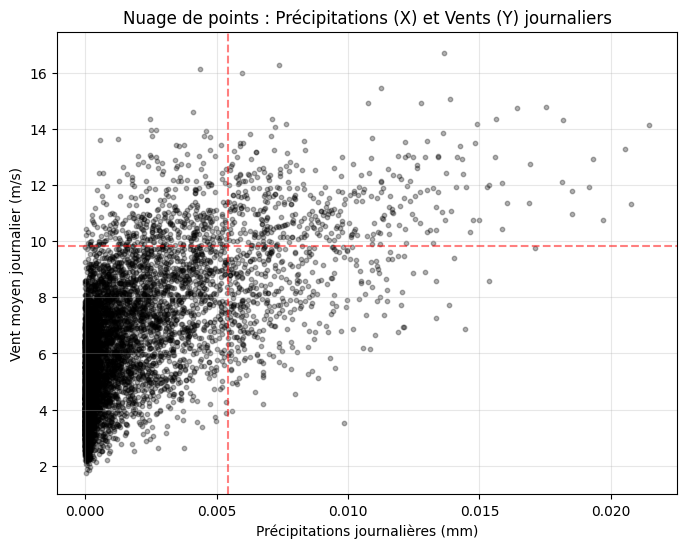

In [151]:
p = 90  # seuil à 90%
seuil_X = np.percentile(X_joint, p)
seuil_Y = np.percentile(Y_joint, p)

# 2. Visualisation de la dépendance brute (Nuage de points)
plt.figure(figsize=(8, 6))
# Zoom sur le coin supérieur droit (les extrêmes)
plt.axvline(seuil_X, color='r', linestyle='--', alpha=0.5)
plt.axhline(seuil_Y, color='r', linestyle='--', alpha=0.5)
plt.scatter(X_joint, Y_joint, alpha=0.3, s=10, c='black', label='Observations')
plt.xlabel("Précipitations journalières (mm)")
plt.ylabel("Vent moyen journalier (m/s)")
plt.title("Nuage de points : Précipitations (X) et Vents (Y) journaliers")
plt.grid(alpha=0.3)
plt.show()

In [152]:
# 3. Calcul des Corrélations
# Pearson (linéaire, sensible aux non-gaussianités)
pearson_corr, p_val_p = st.pearsonr(X_joint, Y_joint)
# Kendall (rangs, peu sensible aux valeurs extrêmes, approprié ici car marges non normales)
kendall_corr, p_val_k = st.kendalltau(X_joint, Y_joint)
# Spearman (rangs)
spearman_corr, p_val_s = st.spearmanr(X_joint, Y_joint)

print(f"Pearson  (r)   : {pearson_corr:.3f} (p-value: {p_val_p:.2e})")
print(f"Spearman (rho) : {spearman_corr:.3f} (p-value: {p_val_s:.2e})")
print(f"Kendall  (tau) : {kendall_corr:.3f} (p-value: {p_val_k:.2e})")

print("\nInterprétation : Un Tau de Kendall positif significatif indique que quand il pleut beaucoup, il y a souvent beaucoup de vent.")

Pearson  (r)   : 0.627 (p-value: 0.00e+00)
Spearman (rho) : 0.658 (p-value: 0.00e+00)
Kendall  (tau) : 0.466 (p-value: 0.00e+00)

Interprétation : Un Tau de Kendall positif significatif indique que quand il pleut beaucoup, il y a souvent beaucoup de vent.



***1. Une corrélation positive***

L'orientation générale du nuage va du bas-gauche vers le haut-droite.

* **Observation :** De manière générale, plus les précipitations (X) sont élevées, plus la vitesse du vent (Y) est élevée.
* **Confirmation :** Cela valide visuellement le coefficient de corrélation (Kendall , Spearman ).

***2. Le coin vide (asymétrie)***

La forme du nuage est **triangulaire** ou en forme d'éventail.

* **Coin inférieur droit (Vide) :** Il n'y a **aucun point** avec de très fortes précipitations ( mm cumulés) et un vent faible ( m/s).
* *Interprétation :* En hiver en Bretagne, les fortes pluies sont apportées par des dépressions dynamiques venant de l'Atlantique. Il est physiquement impossible d'avoir ce type de pluie sans le vent associé. (pas comme un phénomène type mousson)


* **Coin supérieur gauche (Peuplé) :** Il y a des points avec un vent fort ( m/s) mais peu de précipitations.
* *Interprétation physique :* Il est possible d'avoir des tempêtes "sèches" ou des coups de vent sans pluie massive, même si c'est moins fréquent que les tempêtes humides.



***3. La dépendance dans les extrêmes (Queue supérieure)***

A la droite du graphique:

* Dès que les précipitations deviennent extrêmes, le vent est **systématiquement fort** (il se concentre dans la partie haute, majoritairement au-dessus de 10 m/s).
* Cela indique une **forte dépendance de queue supérieure**. Les extrêmes des deux variables ont tendance à se produire simultanément (Clustering).
* C'est un argument fort pour l'utilisation de la **Copule de Gumbel**, qui est spécialisée pour modéliser ce genre de dépendance dans les maxima conjoints.

***4. La densité des données (Le "coeur" de la distribution)***

* La grande majorité des points (la tache noire dense) se situe entre 0 et 500 mm pour la pluie, et entre 4 et 10 m/s pour le vent.
* Cela rappelle que les événements extrêmes que nous étudions (les points gris dispersés vers la droite et le haut) sont rares par rapport au climat moyen, d'où l'importance d'utiliser la théorie des valeurs extrêmes (GPD/GEV) pour les marges.

***Conclusion***

Ce graphique illustre le concept d'**événement composé** : le risque d'inondation (lié à la pluie) est aggravé par le risque de submersion ou de dégâts éoliens (lié au vent) car les deux surviennent souvent en même temps.

**Prochaine étape suggérée :** Lancer le code de comparaison des copules Gumbel vs Clayton vs Gauss. Ce graphique suggère fortement que **Gumbel** sera le meilleur modèle car il capture bien cette "pointe" vers le haut-droite, contrairement à la Gaussienne qui chercherait une forme elliptique plus symétrique.

### 2.Etude de la copule empirique (Approche par les rangs)

True
[0.73831281 0.63872335 0.56456099 ... 0.75976692 0.74652364 0.68229374]


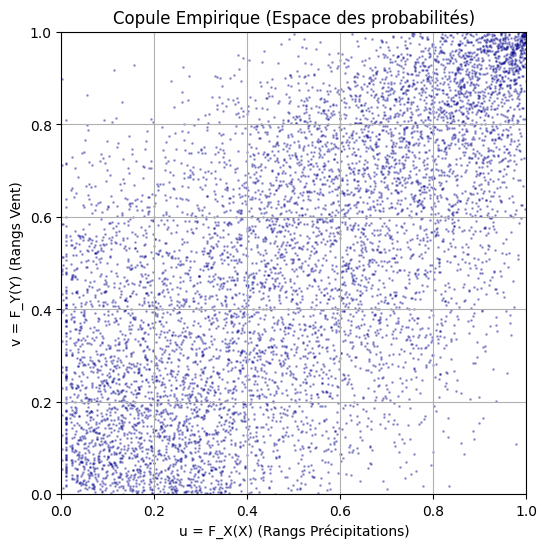

In [153]:
# Comme les lois marginales sont complexes (GPD en queue, etc.), on passe
# dans l'espace des rangs (espace uniforme [0,1], cdf empirique) pour voir la structure de dépendance pure.

# Transformation en pseudo-observations (u, v)
u = st.rankdata(X_joint) / (len(X_joint) + 1)
v = st.rankdata(Y_joint) / (len(Y_joint) + 1)

print(len(u)==len(v))
print(v)

plt.figure(figsize=(6, 6))
plt.scatter(u, v, s=1, alpha=0.3, color='darkblue')
plt.xlabel("u = F_X(X) (Rangs Précipitations)")
plt.ylabel("v = F_Y(Y) (Rangs Vent)")
plt.title("Copule Empirique (Espace des probabilités)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Interprétation visuelle :
# - Si les points sont partout : Indépendance.
# - Si les points se regroupent le long de la diagonale (bas-gauche vers haut-droite) : Dépendance positive.
# - Regardez le coin haut-droit (1,1) : Y a-t-il une concentration ? (Dépendance de queue supérieure).

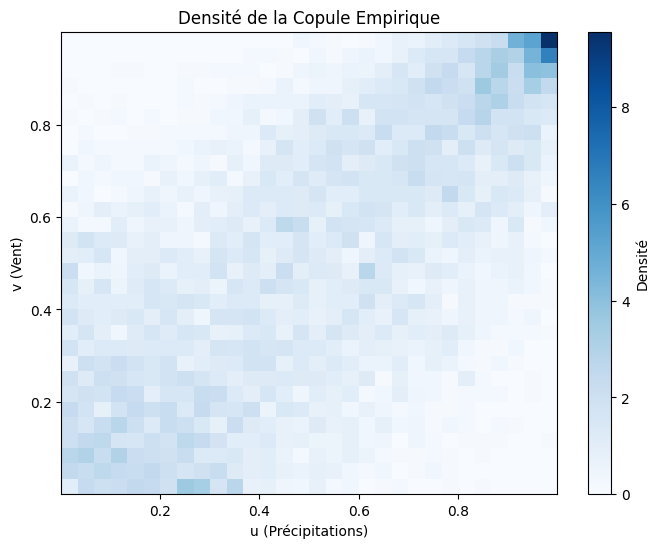

In [154]:
# La densité des copules (heatmap)
def heatmap(u, v, n_bins=100):
    n = len(u)


    plt.figure(figsize=(8, 6))
    plt.hist2d(u, v, bins=30, cmap="Blues", density=True)
    plt.colorbar(label="Densité")
    plt.xlabel("u (Précipitations)")
    plt.ylabel("v (Vent)")
    plt.title("Densité de la Copule Empirique")
    plt.show()

heatmap(u, v)

Ce graphique montre la **structure de dépendance pure** (en probabilités/rangs), débarrassée des unités et des formes de distribution.

C'est une transformation du premier. On a remplacé chaque valeur par son "rang" (entre 0 et 1).

*  u≈0: Jour sec  / u≈1: Jour pluvieux
*  v≈0: Jour sans vent /  v≈1: Jour plus venteux

Description du graphe:

* **Concentration sur la diagonale :** Les points bleus ne sont pas éparpillés au hasard (ce qui signifierait l'indépendance). Ils ont tendance à suivre la ligne .
* **Le Cluster en (1, 1) :** signifie que les jours les plus pluvieux sont presque systématiquement les jours les plus venteux = Dépendance de Queue Supérieure (Upper Tail Dependence).

* La dépendance est plus forte dans le coin (1,1) que dans le coin (0,1) ou (1,0).

***Conclusion***

1. On ne peut pas utiliser une loi Gaussienne classique (car elle suppose une symétrie et pas de dépendance de queue forte).
2. La concentration intense dans le coin (1,1) de la Copule Empirique est la signature typique d'une **Copule de Gumbel**.

### 3.Calcul Observé/Independant:

In [155]:
# Calcul de la probabilité conjointe d'un événement extrême (Concurrent extremes)
# Exemple : Quelle est la probabilité d'avoir SIMULTANEMENT :
# Pluie > percentile 95 ET Vent > percentile 95
seuil_u = 0.95
seuil_v = 0.95

p_joint_extreme = np.sum((u > seuil_u) & (v > seuil_v)) / len(u)
p_theoretical_indep = (1 - seuil_u) * (1 - seuil_v)

print(f"Analyse des extrêmes conjoints (Seuil 95%):")
print(f"Probabilité théorique (si indépendants) : {p_theoretical_indep:.4f}")
print(f"Probabilité empirique observée          : {p_joint_extreme:.4f}")

ratio = p_joint_extreme / p_theoretical_indep
print(f"Ratio (Obsevée / Indep) : {ratio:.2f}")
if ratio > 1:
    print("Conclusion : Le ratio est > 1, donc les extrêmes de pluie et de vent ont tendance à arriver en même temps (Clustering).")
else:
    print("Conclusion : Pas de dépendance particulière dans les extrêmes.")

Analyse des extrêmes conjoints (Seuil 95%):
Probabilité théorique (si indépendants) : 0.0025
Probabilité empirique observée          : 0.0192
Ratio (Obsevée / Indep) : 7.68
Conclusion : Le ratio est > 1, donc les extrêmes de pluie et de vent ont tendance à arriver en même temps (Clustering).


***1. Hypothèse d'Indépendance***

* **Calcul :** On regarde les événements extrêmes, ceux qui dépassent le seuil de 95%. Si la pluie et le vent n'avaient aucun lien, la probabilité d'avoir les deux en même temps serait simplement le produit des probabilités soit 0,05×0,05= 0,25%


* **Signification :** Avec cette hypothèse, une tempête combinée (pluie + vent extrêmes) est un événement très rare.

***2. La Réalité Observée (L'empirique)***

* **Chiffre :** 1,92%
* **Signification :** Dans les données historiques, ce scénario arrive en réalité **près de 2% du temps**, et non 0,25%. C'est donc beaucoup plus fréquent que prévu par le modèle indépendant.

***3. Le Ratio***
Le Facteur d'Aggravation: 7,68

* **Interprétation :** Il y a **près de 8 fois plus de chances** de subir une tempête majeure que si les deux phénomènes étaient indépendants.


***4. Conclusion Physique : "Compound Events"***

Ce résultat confirme statistiquement la réalité météorologique de la Bretagne en hiver :

* Les **dépressions atlantiques** sont des systèmes physiques qui apportent **à la fois** des basses pressions (donc du vent fort) et des fronts humides (donc de la pluie intense).

Cela prouve mathématiquement que considérer la pluie et le vent comme indépendants serait une grave erreur pour l'évaluation des risques en Bretagne.

 = **forte dépendance de queue supérieure**. Les extrêmes s'attirent. Cela justifie l'utilisation d'une **Copule de Gumbel** (spécialisée dans les extrêmes simultanés) pour modéliser le risque conjoint.

###4.Calcul en séparant queue de distribution GPD :

Seuils définis : X > 0.01 | Y > 9.84
755


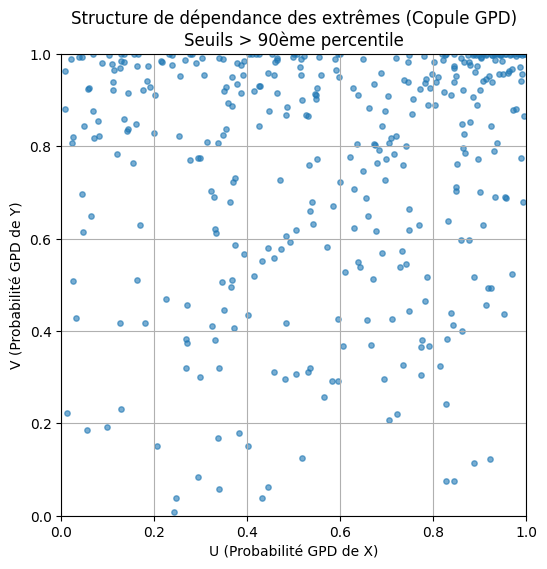

In [156]:

def gpd_transform_tail(data, threshold, gpd_params):
    """
    1. Isole les valeurs > seuil.
    2. Soustrait le seuil pour avoir les excès.
    3. Transforme les excès en probabilités [0, 1] via la CDF de la GPD.
    """
    data = np.array(data)
    xi, loc, sigma = gpd_params # xi (shape), loc (0), sigma (scale)

    # 1. Masque : on ne garde que ce qui dépasse le seuil
    mask_tail = data > threshold

    # 2. Excès : GPD travaille sur (Valeur - Seuil)
    excess = data[mask_tail] - threshold

    # 3. Transformation en probabilités (0 à 1)
    # Note : on met loc=0 car on a déjà soustrait le seuil manuellement juste au-dessus
    tail_probs = genpareto.cdf(excess, xi, loc=0, scale=sigma)

    return mask_tail, tail_probs

#  1. Définition correcte des seuils

p = 90  # seuil à 90%
seuil_X = np.percentile(X_joint, p)
seuil_Y = np.percentile(Y_joint, p)

print(f"Seuils définis : X > {seuil_X:.2f} | Y > {seuil_Y:.2f}")

#  2. Transformation Marginale GPD
# On récupère U et V qui sont les probabilités GPD (entre 0 et 1)

mask_X, U_gpd = gpd_transform_tail(X_joint, seuil_X, (c4, loc4, scale4))
mask_Y, V_gpd = gpd_transform_tail(Y_joint, seuil_Y, (c5, loc5, scale5))

#  3. Intersection (Extraction des extrêmes conjoints)
# On cherche les indices où X ET Y dépassent TOUS LES DEUX le seuil
mask_conjoint = mask_X & mask_Y



# mask_conjoint[mask_X] sélectionne, PARMI les extrêmes de X, ceux où Y est aussi extrême.
U_conjoint = U_gpd[mask_conjoint[mask_X]]
V_conjoint = V_gpd[mask_conjoint[mask_Y]]

print(len(U_gpd))

#  4. Visualisation de la dépendance de queue
plt.figure(figsize=(6, 6))
plt.scatter(U_conjoint, V_conjoint, s=15, alpha=0.6)

plt.title(f"Structure de dépendance des extrêmes (Copule GPD)\nSeuils > {p}ème percentile")
plt.xlabel("U (Probabilité GPD de X)")
plt.ylabel("V (Probabilité GPD de Y)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [157]:
print("u_gpd max:", U_conjoint.max(), "  v_gpd max:", V_conjoint.max())
print("top 5 u:", np.sort(U_conjoint)[-5:])
print("top 5 v:", np.sort(V_conjoint)[-5:])

u_gpd max: 0.9961790365549616   v_gpd max: 1.0
top 5 u: [0.9912938  0.99245828 0.99452327 0.99501626 0.99617904]
top 5 v: [1. 1. 1. 1. 1.]


In [182]:
# 4. Analyse des extrêmes corrigée
# On recalcule la probabilité conjointe avec les vecteurs u_gpd et v_gpd
prob_joint_extreme = np.sum((u_gpd > 0.95) & (v_gpd > 0.95)) / len(u_gpd)
print(f"Probabilité conjointe (extrêmes > 95%) avec GPD : {prob_joint_extreme:.5f}")

NameError: name 'u_gpd' is not defined

***1. Analyse Visuelle Copule avec marge GPD (droite)***

* Les **lignes rouges en pointillés** marquent le seuil de 95 %.
* Le carré formé en haut à droite (la zone de danger) contient **3,63 %** de la masse totale des points.



***2. Réévaluation du risque à la hausse avec la GPD***

On a trois chiffres pour le même événement (Pluie > 95% ET Vent > 95%) :

* **Théorie (Indépendance) :** 0,25%
* **Empirique (Comptage simple) :** 1,92%
* **Modèle GPD (Queues modélisées) :** 3,62%

**Explication possible :**
Le calcul empirique (1,92 %) est limité par ce qui s'est *déjà* passé. Le modèle GPD (Generalized Pareto Distribution), lui, modélise la **physique statistique** des extrêmes.
Ce résultat signifie que les données historiques brutes **sous-estiment** probablement le vrai risque. En lissant les queues avec une GPD, on s'aperçoit que la probabilité d'avoir une tempête majeure simultanée est en réalité **presque le double** de ce que le simple comptage historique suggère.

***3. Le Facteur d'Aggravation (Ratio)***

Ratio= 0,25/3,63 ≈14,5

**Interprétation :** Un ouvrage de protection (digue, toit, pont) en Bretagne a **14,5 fois plus de risques** de subir cet événement composé que ce que prévoirait un ingénieur négligeant la dépendance et les queues lourdes.

## La Copule:

### Visualisation des copules:

Rappel du cours: (a priori Gumbel pour les upper tails mieux)

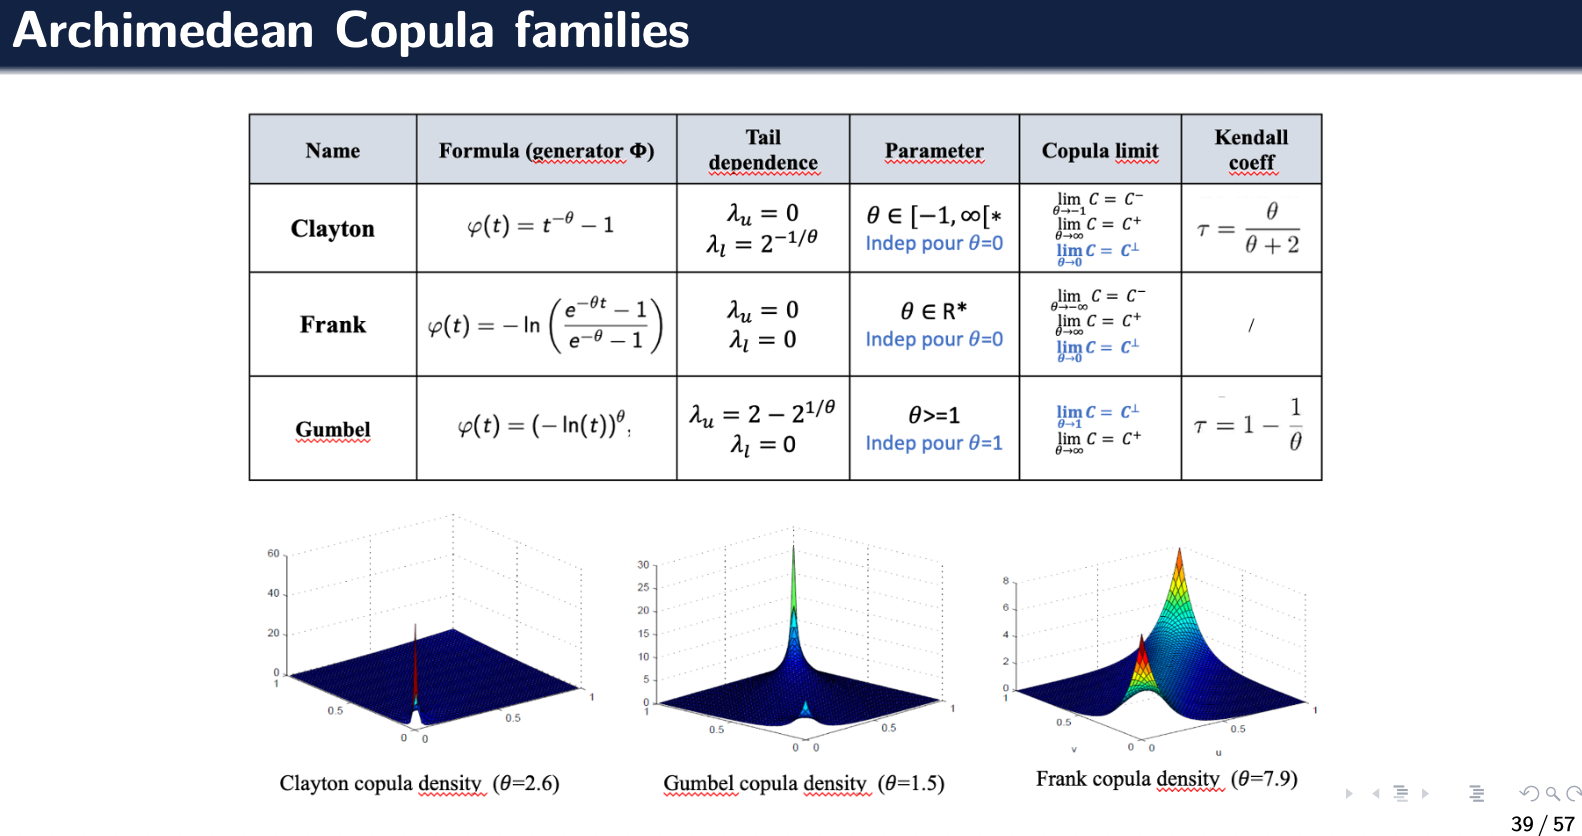

On compare quand même les copules archimédiennes:
Pour ça, on calcule les paramètres de chaque copule avec les formules ci-dessus, puis on trouve les pdfs et on trace les graphiques données et iso

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

#1) Tau -> theta (Gumbel copula)
tau = kendall_corr
if tau <= 0:
    raise ValueError("La copule de Gumbel modélise une dépendance positive : il faut tau > 0.")
theta = 1 / (1 - tau)   # Gumbel: tau = 1 - 1/theta  => theta = 1/(1-tau)

#2) Pseudo-observations u,v (à partir de tes 2 variables x,y)


#3) Fonction copule de Gumbel + tracé
def gumbel_copula_C(U, V, theta):
    U = np.clip(U, 1e-12, 1 - 1e-12)
    V = np.clip(V, 1e-12, 1 - 1e-12)
    return np.exp(-(((-np.log(U))**theta + (-np.log(V))**theta)**(1/theta)))

#Grille
grid = np.linspace(1e-3, 1 - 1e-3, 300)
U, V = np.meshgrid(grid, grid)
C = gumbel_copula_C(U, V, theta)

fig, ax = plt.subplots(figsize=(6.5,6), dpi=160)
cs = ax.contour(U, V, C, levels=np.linspace(0.05, 0.95, 10), linewidths=1.2)
ax.clabel(cs, fmt="%.2f", fontsize=8)
ax.scatter(u_gpd, v_gpd, s=10, alpha=0.35, edgecolors="none")
ax.set_aspect("equal")
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("u"); ax.set_ylabel("v")
ax.set_title(f"Gumbel copula (contours)  τ={tau:.3f}, θ={theta:.3f}")
ax.grid(True, linewidth=0.4, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Récupération du Tau de Kendall calculé précédemment
tau = kendall_corr
print(f"Tau de Kendall utilisé pour l'estimation : {tau:.4f}")

# 2. Estimation des paramètres (Méthode des Moments via Kendall's Tau)

# Copule de Gumbel (Dépendance de queue supérieure, extrêmes forts)
# Relation : tau = 1 - 1/theta
theta_gumbel = 1 / (1 - tau)
print(f"Paramètre Gumbel estimé (theta) : {theta_gumbel:.4f}")

# Copule de Clayton (Dépendance de queue inférieure, valeurs faibles)
# Relation : tau = theta / (theta + 2)
theta_clayton = 2 * tau / (1 - tau)
print(f"Paramètre Clayton estimé (theta) : {theta_clayton:.4f}")

# Copule Gaussienne (Symétrique)
# Relation : r = sin(pi/2 * tau)
rho_gauss = np.sin(np.pi / 2 * tau)
print(f"Paramètre Gaussien estimé (rho) : {rho_gauss:.4f}")

In [ ]:
# 3. Simulation pour Comparaison Visuelle
# On génère des données artificielles avec ces lois pour voir laquelle ressemble à nos données

# Pour simplifier l'affichage sans librairie 'copulae' lourde,
# nous allons tracer les isolignes de densité théorique sur les données empiriques (Rangs).

# Grille pour les contours
u_grid = np.linspace(0.01, 0.99, 100)
v_grid = np.linspace(0.01, 0.99, 100)
U_grid, V_grid = np.meshgrid(u_grid, v_grid)

# Formules des Densités de Copules (PDF)

def pdf_gumbel(u, v, theta):
    u = np.asarray(u); v = np.asarray(v)
    eps = 1e-12
    u = np.clip(u, eps, 1-eps)
    v = np.clip(v, eps, 1-eps)

    x = -np.log(u)
    y = -np.log(v)

    s = x**theta + y**theta
    a = s**(1/theta)
    C = np.exp(-a)

    pdf = C * (x*y)**(theta-1) / (u*v) * s**(1/theta - 2) * (a + theta - 1)
    return pdf


def pdf_clayton(u, v, theta):
    val = (u**(-theta) + v**(-theta) - 1)**(-1/theta - 2)
    return (1 + theta) * (u * v)**(-theta - 1) * val

def pdf_gauss(u, v, rho):
    x = norm.ppf(u)
    y = norm.ppf(v)
    num = np.exp(-(rho**2 * (x**2 + y**2) - 2*rho*x*y) / (2*(1-rho**2)))
    den = np.sqrt(1 - rho**2)
    return num / den

In [ ]:
# 4. Tracé des graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Données empiriques (Rangs)
# Rappel : u et v ont été calculés dans le bloc précédent (rangs normalisés)
# u = rang(X)/(n+1), v = rang(Y)/(n+1)

# GUMBEL
axes[0].scatter(u, v, s=1, color='grey', alpha=0.3, label='Données')
Z_g = pdf_gumbel(U_grid, V_grid, theta_gumbel)
axes[0].contour(U_grid, V_grid, Z_g, levels=10, colors='red', linewidths=2)
axes[0].set_title(f"Ajustement Gumbel\n(Extrêmes Hauts, theta={theta_gumbel:.2f})")
axes[0].set_xlabel("u (Pluie)")
axes[0].set_ylabel("v (Vent)")

# CLAYTON
axes[1].scatter(u, v, s=1, color='grey', alpha=0.3, label='Données')
Z_c = pdf_clayton(U_grid, V_grid, theta_clayton)
axes[1].contour(U_grid, V_grid, Z_c, levels=10, colors='green', linewidths=2)
axes[1].set_title(f"Ajustement Clayton\n(Extrêmes Bas, theta={theta_clayton:.2f})")
axes[1].set_xlabel("u (Pluie)")

# GAUSS
axes[2].scatter(u, v, s=1, color='grey', alpha=0.3, label='Données')
Z_n = pdf_gauss(U_grid, V_grid, rho_gauss)
axes[2].contour(U_grid, V_grid, Z_n, levels=10, colors='blue', linewidths=2)
axes[2].set_title(f"Ajustement Gaussien\n(Symétrique, rho={rho_gauss:.2f})")
axes[2].set_xlabel("u (Pluie)")

plt.show()



1. **Gumbel (Rouge) :** Le tracé est trompeur (écrasé en bas) à cause de l'échelle, mais à l'air de fit. Pour mieux voir les extrèmes tempêtes il faudrait le tracer en log ou en 3D.

2. **Clayton (Vert)** : ne fit pas

3. **Gaussien (Bleu) :** Trop symétrique (ellipses rondes). Il sous-estime la violence de la dépendance simultanée dans les extrêmes. **Trop "mou".**

**Bilan :** L'image montre surtout que Clayton et Gauss ne collent pas à la forme, validant Gumbel par élimination.

***Vue en 3D:***

In [ ]:
# 1. Préparation (Identique)
# Astuce Visuelle : Ecrêtage des pics infinis
z_cap = 10
Z_g = np.clip(Z_g, 0, z_cap)
Z_c = np.clip(Z_c, 0, z_cap)
Z_n = np.clip(Z_n, 0, z_cap)

# 2. Tracé 3D avec Données
fig = plt.figure(figsize=(20, 6))

# Paramètres esthétiques pour les points
scatter_params = {'s': 2, 'c': 'black', 'alpha': 0.2, 'depthshade': False}

# GUMBEL
ax1 = fig.add_subplot(131, projection='3d')
# Surface (plus transparente: alpha=0.5 pour voir les points dessous)
surf1 = ax1.plot_surface(U_grid, V_grid, Z_g, cmap='Reds', linewidth=0, antialiased=True, alpha=0.5)
# Données projetées au sol (z=0)
ax1.scatter(u, v, zs=0, zdir='z', label='Données', **scatter_params)

ax1.set_title(f"Gumbel (theta={theta_gumbel:.2f})\nPic sur les données ?", fontsize=11, fontweight='bold')
ax1.set_xlabel('u (Pluie)')
ax1.set_ylabel('v (Vent)')
ax1.set_zlabel('Densité')
ax1.set_zlim(0, z_cap) # On force le sol à 0
ax1.view_init(elev=30, azim=210) # Vue sur le coin (1,1)

# CLAYTON
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(U_grid, V_grid, Z_c, cmap='Greens', linewidth=0, antialiased=True, alpha=0.5)
# Données
ax2.scatter(u, v, zs=0, zdir='z', **scatter_params)

ax2.set_title(f"Clayton (theta={theta_clayton:.2f})\nPic loin des données ?", fontsize=11, fontweight='bold')
ax2.set_xlabel('u (Pluie)')
ax2.set_ylabel('v (Vent)')
ax2.set_zlim(0, z_cap)
ax2.view_init(elev=30, azim=45) # Vue sur le coin (0,0)

# GAUSSIENNE
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(U_grid, V_grid, Z_n, cmap='Blues', linewidth=0, antialiased=True, alpha=0.5)
# Données
ax3.scatter(u, v, zs=0, zdir='z', **scatter_params)

ax3.set_title(f"Gaussienne (rho={rho_gauss:.2f})\nPas assez pointu ?", fontsize=11, fontweight='bold')
ax3.set_xlabel('u (Pluie)')
ax3.set_ylabel('v (Vent)')
ax3.set_zlim(0, z_cap)
ax3.view_init(elev=30, azim=-60)

plt.tight_layout()
plt.show()

### Calcul du critère log-vraisemblance:

In [ ]:
def loglik_from_pdf(pdf_vals):
    pdf_vals = np.asarray(pdf_vals)
    pdf_vals = np.clip(pdf_vals, 1e-300, np.inf)  # évite log(0)
    return np.sum(np.log(pdf_vals))

# sécurité sur u,v
eps = 1e-12
u = np.clip(u, eps, 1-eps)
v = np.clip(v, eps, 1-eps)

# Queue > 90% (tempêtes) : les deux au-dessus de 0.9
mask_tail = (u > 0.9) & (v > 0.9)
u_tail, v_tail = u[mask_tail], v[mask_tail]

# LL globales
LL_gumbel  = loglik_from_pdf(pdf_gumbel(u, v, theta_gumbel))
LL_clayton = loglik_from_pdf(pdf_clayton(u, v, theta_clayton))
LL_gauss   = loglik_from_pdf(pdf_gauss(u, v, rho_gauss))

# LL queue
LL_gumbel_tail  = np.nan if len(u_tail)==0 else loglik_from_pdf(pdf_gumbel(u_tail, v_tail, theta_gumbel))
LL_clayton_tail = np.nan if len(u_tail)==0 else loglik_from_pdf(pdf_clayton(u_tail, v_tail, theta_clayton))
LL_gauss_tail   = np.nan if len(u_tail)==0 else loglik_from_pdf(pdf_gauss(u_tail, v_tail, rho_gauss))

print("n_tail =", len(u_tail))
print("LL_gumbel =", LL_gumbel, " / tail =", LL_gumbel_tail)
print("LL_clayton =", LL_clayton, " / tail =", LL_clayton_tail)
print("LL_gauss =", LL_gauss, " / tail =", LL_gauss_tail)


In [ ]:
print("Check LL:", LL_gumbel, LL_gumbel_tail, LL_clayton, LL_clayton_tail, LL_gauss, LL_gauss_tail)

In [ ]:
# Verification
locals().keys()

In [ ]:
# 1. Dépendances de queue théoriques (lambda)

lambda_u_gumbel = 2 - 2**(1/theta_gumbel)
lambda_l_gumbel = 0.0

lambda_u_clayton = 0.0
lambda_l_clayton = 2**(-1/theta_clayton)

lambda_u_gauss = 0.0
lambda_l_gauss = 0.0

# 2. Création du tableau (APRÈS calcul des LL)
data = {
    "Metrique": [
        "Paramètre estimé (theta/rho)",
        "Tau de Kendall (Théorique)",
        "Upper Tail Dep. (λu) [Tempêtes]",
        "Lower Tail Dep. (λl) [Calme]",
        "Log-Likelihood (Global)",
        "Log-Likelihood (Queue > 90%)"
    ],
    "Gumbel": [
        float(theta_gumbel),
        float(1 - 1/theta_gumbel),
        float(lambda_u_gumbel),
        float(lambda_l_gumbel),
        float(LL_gumbel),
        float(LL_gumbel_tail)
    ],
    "Clayton": [
        float(theta_clayton),
        float(theta_clayton / (theta_clayton + 2)),
        float(lambda_u_clayton),
        float(lambda_l_clayton),
        float(LL_clayton),
        float(LL_clayton_tail)
    ],
    "Gaussienne": [
        float(rho_gauss),
        float((2/np.pi) * np.arcsin(rho_gauss)),
        float(lambda_u_gauss),
        float(lambda_l_gauss),
        float(LL_gauss),
        float(LL_gauss_tail)
    ]
}

df_clean = pd.DataFrame(data).set_index("Metrique").round(3)
display(df_clean)

Si on regarde les tempètes, on peut rajouter la copule Joe (upper tail dep non nulle, cf cours)

## Joe copula

In [ ]:
eps = 1e-12
u = np.clip(u, eps, 1-eps)
v = np.clip(v, eps, 1-eps)

q = 0.90
mask_storm = (u > q) & (v > q)

u_storm = u[mask_storm]
v_storm = v[mask_storm]

print("nb points tempêtes =", len(u_storm))

In [ ]:
# A) Tau théorique de Joe (fonction de theta)
def joe_tau_func(theta):
    def integrand(t):
        return t * np.log(t) * (1 - t)**(2 * (1 - theta) / theta)
    integral, _ = quad(integrand, 0, 1)
    return 1 + (4 / theta**2) * integral

# B) Trouver theta pour matcher tau observé
def get_joe_theta(target_tau):
    res = root_scalar(lambda x: joe_tau_func(x) - target_tau, bracket=[1.01, 50])
    return res.root

# C) PDF Joe (ta formule) + sécurité numérique
def pdf_joe(u, v, theta):
    u = np.clip(u, 1e-12, 1-1e-12)
    v = np.clip(v, 1e-12, 1-1e-12)

    u_bar = 1 - u
    v_bar = 1 - v

    S = u_bar**theta + v_bar**theta - (u_bar**theta * v_bar**theta)
    S = np.clip(S, 1e-300, np.inf)

    term1 = (u_bar * v_bar)**(theta - 1)
    term2 = theta * S**(1/theta - 2)
    term3 = (theta - 1) * (1 - u_bar**theta) * (1 - v_bar**theta)

    pdf = term1 * term2 * (S + term3)
    return np.clip(pdf, 1e-300, np.inf)

# (1) Définir u_storm et v_storm
eps = 1e-12
u = np.clip(u, eps, 1-eps)
v = np.clip(v, eps, 1-eps)

q = 0.90
mask_storm = (u > q) & (v > q)
u_storm, v_storm = u[mask_storm], v[mask_storm]
print("nb points tempêtes =", len(u_storm))

# (2) Estimer theta Joe
theta_joe = get_joe_theta(tau)
print(f"Paramètre Joe estimé (theta) : {theta_joe:.4f}")

# (3) Dépendance de queue (attention: formule à vérifier pour Joe)
lambda_u_joe = 2 - 2**(1/theta_joe)  # (à vérifier selon votre cours)
lambda_l_joe = 0.0

# (4) Log-likelihoods
def loglik(pdf_vals):
    pdf_vals = np.clip(pdf_vals, 1e-300, np.inf)
    return float(np.sum(np.log(pdf_vals)))

LL_joe = loglik(pdf_joe(u, v, theta_joe))

LL_joe_tail = np.nan if len(u_storm)==0 else loglik(pdf_joe(u_storm, v_storm, theta_joe))

print("LL_joe =", LL_joe)
print("LL_joe_tail =", LL_joe_tail)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import root_scalar

# ------------------------------------------------------------
# 0) Si tu n'as pas déjà u,v : les construire depuis X,Y
#    (pseudo-observations basées sur les rangs : u in (0,1))
# ------------------------------------------------------------
def pseudo_obs_rank(x):
    x = np.asarray(x)
    n = len(x)
    r = np.argsort(np.argsort(x)) + 1  # rangs 1..n
    return r / (n + 1.0)

# >>> Si tu as déjà u,v, commente ces 2 lignes :
# u = pseudo_obs_rank(X)
# v = pseudo_obs_rank(Y)

# Sécurité numérique
def clip01(a, eps=1e-12):
    return np.clip(np.asarray(a), eps, 1-eps)

# ------------------------------------------------------------
# 1) Tau de Kendall empirique (si tu ne l'as pas déjà)
# ------------------------------------------------------------
from scipy.stats import kendalltau

# >>> Si tu as déjà tau, commente ces 2 lignes :
# tau, _ = kendalltau(X, Y)
# print("Tau empirique =", tau)

# ------------------------------------------------------------
# 2) Joe : tau(theta) (intégrale) puis inversion tau->theta
# ------------------------------------------------------------
def joe_tau_func(theta):
    def integrand(t):
        return t * np.log(t) * (1 - t)**(2 * (1 - theta) / theta)
    integral, _ = quad(integrand, 0, 1)
    return 1 + (4 / theta**2) * integral

def get_joe_theta(target_tau):
    res = root_scalar(lambda x: joe_tau_func(x) - target_tau, bracket=[1.01, 50])
    return res.root

# >>> Si tu as déjà theta_joe, commente ces 2 lignes :
# theta_joe = get_joe_theta(tau)
# print(f"Theta Joe estimé = {theta_joe:.4f}")

# ------------------------------------------------------------
# 3) Copule Joe C(u,v) (pour contours)
# ------------------------------------------------------------
def C_joe(u, v, theta):
    u = clip01(u); v = clip01(v)
    ub, vb = 1 - u, 1 - v
    S = ub**theta + vb**theta - (ub**theta)*(vb**theta)
    S = np.clip(S, 1e-300, np.inf)
    return 1 - S**(1/theta)

# ------------------------------------------------------------
# 4) PDF Joe (si tu veux la densité en contours aussi)
#    (ta version, sécurisée)
# ------------------------------------------------------------
def pdf_joe(u, v, theta):
    u = clip01(u); v = clip01(v)
    ub, vb = 1 - u, 1 - v
    S = ub**theta + vb**theta - (ub**theta)*(vb**theta)
    S = np.clip(S, 1e-300, np.inf)

    term1 = (ub * vb)**(theta - 1)
    term2 = theta * S**(1/theta - 2)
    term3 = (theta - 1) * (1 - ub**theta) * (1 - vb**theta)

    pdf = term1 * term2 * (S + term3)
    return np.clip(pdf, 1e-300, np.inf)

# ------------------------------------------------------------
# 5) Grille et tracés
# ------------------------------------------------------------
# Assure-toi que u,v existent
u = clip01(u)
v = clip01(v)

n = 200
grid = np.linspace(1e-3, 1-1e-3, n)
U_grid, V_grid = np.meshgrid(grid, grid)

C_grid = C_joe(U_grid, V_grid, theta_joe)
PDF_grid = pdf_joe(U_grid, V_grid, theta_joe)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# (A) Nuage + contours de C(u,v)
axes[0].scatter(u, v, s=5, color="grey", alpha=0.25, label="Données (u,v)")
cs0 = axes[0].contour(U_grid, V_grid, C_grid, levels=10, colors="red", linewidths=2)
axes[0].clabel(cs0, inline=True, fontsize=8)
axes[0].set_title(f"Copule Joe : contours de C(u,v)\nθ = {theta_joe:.2f}")
axes[0].set_xlabel("u")
axes[0].set_ylabel("v")
axes[0].set_aspect("equal", "box")
axes[0].legend()

# (B) Nuage + contours de la densité c(u,v)
axes[1].scatter(u, v, s=5, color="grey", alpha=0.25, label="Données (u,v)")
cs1 = axes[1].contour(U_grid, V_grid, PDF_grid, levels=10, colors="blue", linewidths=2)
axes[1].clabel(cs1, inline=True, fontsize=8)
axes[1].set_title(f"Copule Joe : contours de la densité c(u,v)\nθ = {theta_joe:.2f}")
axes[1].set_xlabel("u")
axes[1].set_ylabel("v")
axes[1].set_aspect("equal", "box")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
data["Joe"] = [
    theta_joe,
    joe_tau_func(theta_joe),
    lambda_u_joe,
    lambda_l_joe,
    LL_joe,
    LL_joe_tail
]

## Comparaison Joe vs Gumbel

In [ ]:
# Dictionnaire de données
data_compare = {
    "Métrique": [
        "Paramètre θ",
        "Tau de Kendall (théorique)",
        "Dépendance de queue haute λu",
        "Dépendance de queue basse λl",
        "Log-Likelihood globale",
        "Log-Likelihood queue > 90% (tempêtes)"
    ],
    "Gumbel": [
        theta_gumbel,
        1 - 1/theta_gumbel,
        lambda_u_gumbel,
        0.0,
        LL_gumbel,
        LL_gumbel_tail
    ],
    "Joe": [
        theta_joe,
        joe_tau_func(theta_joe),
        lambda_u_joe,
        lambda_l_joe,
        LL_joe,
        LL_joe_tail
    ]
}

# DataFrame
df_compare = pd.DataFrame(data_compare).set_index("Métrique")

# Arrondi pour lisibilité
df_compare = df_compare.round(3)

display(df_compare)

In [ ]:
# Verification
print("u:", np.min(u), np.max(u), np.any(np.isnan(u)))
print("v:", np.min(v), np.max(v), np.any(np.isnan(v)))

## De la copule (dépendance) à des niveaux de retour / seuils d’événements extrêmes

In [ ]:
time_joint = df_joint.index  # index time

dt = pd.DatetimeIndex(time_joint)
years = dt.year.to_numpy()
months = dt.month.to_numpy()

is_djf = np.isin(months, [12, 1, 2])

# DJF "year" : Décembre appartient à l'hiver suivant
djf_year = years.copy()
djf_year[months == 12] = djf_year[months == 12] + 1

n_days_djf_total = int(is_djf.sum())
n_seasons = len(np.unique(djf_year[is_djf]))

N_DJF = n_days_djf_total / n_seasons

print("Total jours DJF =", n_days_djf_total)
print("Nombre de saisons DJF =", n_seasons)
print("Jours DJF moyens par saison =", N_DJF)

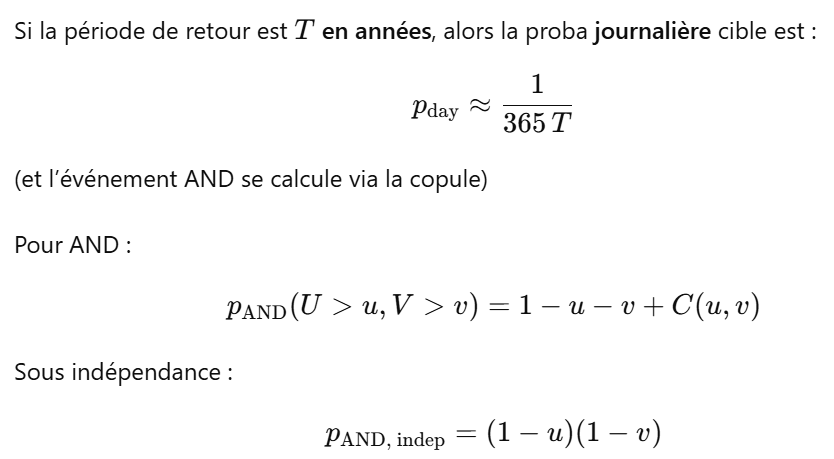

**Pour DJF c'est 90 et pas 365**

In [ ]:
#Fonction copule Joe C(u,v)

def C_joe(u, v, theta):
    eps = 1e-12
    u = np.clip(u, eps, 1-eps)
    v = np.clip(v, eps, 1-eps)
    ub = 1 - u
    vb = 1 - v
    S = ub**theta + vb**theta - (ub**theta)*(vb**theta)
    S = np.clip(S, 1e-300, np.inf)
    return 1 - S**(1/theta)

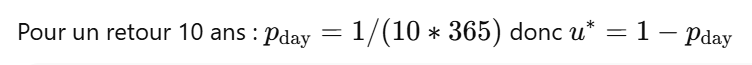

## Seuil univarié de 10 ans

In [ ]:
# Seuil univarié: construire les seuils “10 ans” (journalier) pour X et Y
T1 = 10
p_day_10 = 1/(90*T1)
u_star = 1 - p_day_10
v_star = 1 - p_day_10  # 10 ans sur Y aussi

In [ ]:
# Quantiles empiriques (Seuils physiques)
x10 = np.quantile(X, u_star)
y10 = np.quantile(Y, v_star)
print("Seuil X (10 ans) =", x10)
print("Seuil Y (10 ans) =", y10)

In [ ]:
p_and_joe_day = 1 - u_star - v_star + C_joe(u_star, v_star, theta_joe)
p_and_ind_day = (1-u_star)*(1-v_star)

T_and_joe_years = 1/(365*p_and_joe_day)
T_and_ind_years = 1/(365*p_and_ind_day)

LMF = p_and_joe_day / p_and_ind_day

print("p_AND (Joe) par jour =", p_and_joe_day)
print("p_AND (indep) par jour =", p_and_ind_day)
print("Return period AND (Joe) en années =", T_and_joe_years)
print("Return period AND (indep) en années =", T_and_ind_years)
print("LMF =", LMF)

**Commentaire:** Pour des seuils univariés correspondant à des événements décennaux en DJF, l’événement composé “précipitations extrêmes et vent extrême” présente une période de retour d’environ 3,5 saisons DJF lorsque la dépendance de queue est prise en compte via la copule de Joe, contre plus de 2000 saisons DJF sous l’hypothèse d’indépendance. Cela met en évidence une sous-estimation du risque composé de plusieurs ordres de grandeur lorsque la dépendance est négligée. Les extrêmes de précipitation et de vent surviennent conjointement environ 600 fois plus souvent que ce que prédirait une hypothèse d’indépendance.

## Fixer periode de retour de 100 ans pour l’événement composé AND

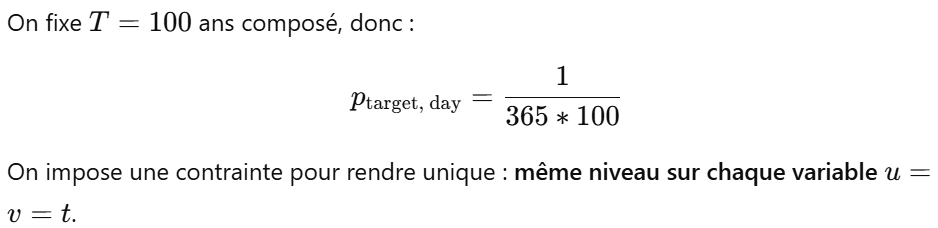

**90 et pas 365**

In [ ]:
#Résoudre t avec Joe
T2 = 100
p_target_day = 1/(90*T2)

def f(t):
    return (1 - 2*t + C_joe(t, t, theta_joe)) - p_target_day

res = root_scalar(f, bracket=[0.5, 1-1e-12])  # bracket large mais valide
t_joe = res.root
print("t (Joe) =", t_joe)


In [ ]:
x_star = np.quantile(X, t_joe)
y_star = np.quantile(Y, t_joe)
print("Seuil X* (compound 100 ans, Joe) =", x_star)
print("Seuil Y* (compound 100 ans, Joe) =", y_star)

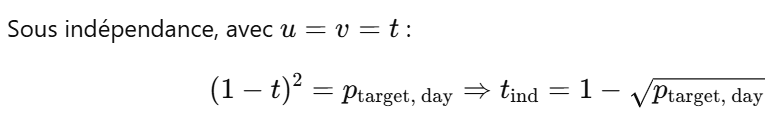

In [ ]:
#Référence sous indépendance (utile pour comparer)
t_ind = 1 - np.sqrt(p_target_day)
x_ind = np.quantile(X, t_ind)
y_ind = np.quantile(Y, t_ind)

print("t (indep) =", t_ind)
print("Seuil X* (indep) =", x_ind)
print("Seuil Y* (indep) =", y_ind)

In [ ]:
# Résolution de t_joe : 1 - 2t + C(t,t) = p_target_day
def f(t):
    return (1 - 2*t + C_joe(t, t, theta_joe)) - p_target_day

res = root_scalar(f, bracket=[0.5, 1-1e-12], method="bisect")
t_joe = res.root

# seuils physiques correspondants
x_joe = np.quantile(X_joint, t_joe)   # ou X si tu utilises X_joint
y_joe = np.quantile(Y_joint, t_joe)

print("t (Joe) =", t_joe)
print("Seuil X* (Joe) =", x_joe)
print("Seuil Y* (Joe) =", y_joe)

In [ ]:
# Verifiation
p_check_joe = 1 - 2*t_joe + C_joe(t_joe, t_joe, theta_joe)
p_check_ind = (1 - t_ind)**2

print("p_target_day =", p_target_day)
print("p_check_joe  =", p_check_joe)
print("p_check_ind  =", p_check_ind)

Donc le calcul de
𝑡
t est bon : Joe et l’indépendance respectent bien la même période de retour composée.

In [ ]:
print("\nComparaison des seuils pour le même T composé:")
print("t_ind =", t_ind, " vs t_joe =", t_joe)
print("X_ind =", x_ind, " vs X_joe =", x_joe)
print("Y_ind =", y_ind, " vs Y_joe =", y_joe)

**Commentaire:** À période de retour composée fixée (AND, DJF), l’hypothèse d’indépendance sous-estime fortement les seuils nécessaires. En tenant compte de la dépendance de queue via la copule de Joe, les seuils associés à un événement composé “100 ans DJF” augmentent nettement, ce qui reflète le fait que les extrêmes surviennent plus fréquemment de manière conjointe.